# GUESS MY WEIGHT 

![guess_your_weight.gif](images/guess_your_weight.gif)

## Table of Contents TOC
[Overview](#overview)<br />
[Data Understanding](#data-understanding)<br />
[Data Preparation](#data-preparation)<br />
[Modeling](#modeling)<br />
[Evaluation](#evaluation)<br />
[Github Repository and Resources](#github-repository-and-resources)<br />


## Overview
Health and Wellness is a big business. Specifically, weight loss. We’re all trying because it’s very, very hard. I recently went on my own weight loss journey, losing about 50 lbs in roughly 18 months. Weighing myself every morning, I agonized over every tenth of a lb, recording it in an app on my phone. I realized that losing big chunks of weights starts with small, incremental progress on the scale. But I didn’t stop there. As a data nerd I thought, “let’s record every meal.” So I did that too. I wondered… given all this data I have, could I predict my weight? My watch and phone captures my exercise, sleep, eating, and so much more. There must be trends here. At a minimum, I should be able to predict whether my weight will go up or down from the previous day. So let’s do it.<br />
[return to TOC](#table-of-contents-TOC)

## Data Understanding
I have much (and probably too much) of this data in my iphone and Apple Watch. It contains the weight information, workouts, heart rate, meals - broken down into subcategories (proteins, fats, etc). Most importantly is the weight. That will be the feature that I primarily use for classification.  

Because it’s my data, there’s more clarity about data entry methods. This is more subjective, than a controlled experiment with many participants. I know what data I was diligent about collecting so I should be able to scrub it appropriately. For instance, I didn’t record my fluids consistently - water, tea, coffee. Water consumption is a big part of this so I’ll have to be clear about the gaps in the data.<br />
[return to TOC](#table-of-contents-TOC)


## Data Preparation
The data is stored on a csv file in a kaggle repository.

in an xml file on my phone. After downloading it into python notebook and digging a little, there are roughly 180 rows of weight entries (approximately 6 months) but it’s not clear how many gaps there are. All of the data is stored as an entry, with time stamps and usually some numeric form. Whether it’s heart rate, weight, caloric info, it’s one numeric entry with an associated units. We’re primarily dealing with ints and floats, all numeric, and we’ll be using daily totals/averages. Because we only have one weigh-in per day, we’re only going to use daily values of other data. So… we know we have approximately 100-180 rows. I can’t say at the moment how many columns, because this will be based on what happens in pre-processing. Which brings me to../.

There are two major challenges with the pre-processing. The first deals with the privacy of my personal health data. How do I balance reproducibility requirements with privacy concerns? I need to make the dataset publicly available, including all of my pre-processing steps, but I also want to make sure no one can link it back to me, Andrew Q. Bennett (my real middle name doesn’t start with Q… gotcha!!!!). And the initial dataset is large, maybe 40 MB. The approach we’ll use is to perform some pre-processing locally, and then upload to the kaggle site when it’s ready for public consumption. In my jupyter notebook, I will comment out some of this code so that we can see the work, but it won’t affect the code when we press “run”.

The second is dealing with correlation efforts. For instance, we know that all data related to working out is going to be correlated with eachother. The steps, average heart rate, workout calories, etc will all be correlated to whether I went for a jog that day. Making decisions about which data to use will be a challenge, even with some baseline domain knowledge. There is a treasure trove that may have nothing (or very little) to do with weight loss, like Vitamin A intake. PCA Analysis will be critical without losing some data. I know about health…but I’m no expert. Maybe Vitamin A intake can help/hurt weight loss.

The many visualization efforts will come from making sure the weight data is presented cleanly. A nice, regression line showing weight trends over different periods will be very helpful.<br />
[return to TOC](#table-of-contents-TOC)

### Instructions for Google Colab
Do not run the code snippet below. This is merely a reference if you'd like to download the dataset from Kaggle. Uncomment the below code snippet for downloading datasets from kaggle in Google Colab, the very first time.  

In [2693]:
! pip install opendatasets
! pip install kaggle

In [2694]:
import opendatasets as od
import pandas
 
od.download(
    "https://www.kaggle.com/datasets/andrewmbennett/guess-my-weight-4-25")

Skipping, found downloaded files in ".\guess-my-weight-4-25" (use force=True to force download)


In [2696]:
import pandas as pd
import datetime as dt
import numpy as np
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf

### Importing csv file

In [2697]:
df = pd.read_csv('/content/guess-my-weight-4-25/merge_health_4_25.csv')

In [2698]:
df

,date,BodyMass_lb,StepCount_count,DistanceWalkingRunning_mi,BasalEnergyBurned_Cal,ActiveEnergyBurned_Cal,FlightsClimbed_count,DietaryFatTotal_g,DietaryFatPolyunsaturated_g,DietaryFatMonounsaturated_g,...,DietaryZinc_mg,DietarySelenium_mcg,DietaryCopper_mg,DietaryManganese_mg,DietaryPotassium_mg,AppleExerciseTime_min,SleepAnalysis_AsleepDeep_hrs,SleepAnalysis_AsleepCore_hrs,SleepAnalysis_AsleepREM_hrs,SleepAnalysis_Awake_hrs
0,2023-08-24,196.9,8895.0,4.163569,2055.322,564.7780,24.0,159.7455,11.8,9.5,...,0.5,9.0,0.3,1.1,1572.0,12.0,0.783333,5.558333,1.766667,0.266667
1,2023-08-25,195.1,9276.0,4.512434,2174.950,793.3800,7.0,62.9275,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,36.0,1.008333,3.700000,1.500000,0.133333
2,2023-08-26,195.1,10883.0,4.948209,2074.476,395.3870,9.0,118.3000,8.3,15.0,...,1.4,13.0,0.5,0.8,1943.0,8.0,1.400000,3.916667,1.558333,0.050000
3,2023-08-27,192.9,19174.0,9.909258,2187.383,895.4360,14.0,79.9300,3.1,2.9,...,1.5,18.0,0.3,0.5,1986.0,45.0,0.891667,5.566667,2.591667,0.066667
4,2023-08-28,192.9,13636.0,6.833914,2186.244,901.5490,21.0,70.8500,4.6,7.1,...,1.3,17.0,0.3,0.9,455.0,43.0,0.641667,5.275000,2.008333,0.158333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,2024-03-04,175.7,8191.0,4.051709,1983.933,499.0720,4.0,87.7000,7.9,9.9,...,2.8,58.0,0.3,2.8,1023.0,76.0,0.000000,0.000000,0.000000,0.000000
194,2024-03-05,174.2,8882.0,4.448750,2009.083,566.5723,9.0,88.6000,4.8,6.3,...,1.9,123.0,0.1,0.8,2387.0,135.0,0.816667,4.775000,1.858333,2.683333
195,2024-03-06,173.3,2610.0,1.272886,759.761,127.8580,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
196,2023-08-23,NaN,7325.0,3.399540,2057.531,476.7400,17.0,80.7000,1.8,0.9,...,0.5,2.0,0.2,0.5,422.0,10.0,0.983333,3.400000,1.091667,0.241667


One of the first things will do is make the date the index and convert date to

### Date Column Feature and Formatting

In [2699]:
#convert the date
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [2700]:
df['day'] = df['date'].dt.day_name()
df

,date,BodyMass_lb,StepCount_count,DistanceWalkingRunning_mi,BasalEnergyBurned_Cal,ActiveEnergyBurned_Cal,FlightsClimbed_count,DietaryFatTotal_g,DietaryFatPolyunsaturated_g,DietaryFatMonounsaturated_g,...,DietarySelenium_mcg,DietaryCopper_mg,DietaryManganese_mg,DietaryPotassium_mg,AppleExerciseTime_min,SleepAnalysis_AsleepDeep_hrs,SleepAnalysis_AsleepCore_hrs,SleepAnalysis_AsleepREM_hrs,SleepAnalysis_Awake_hrs,day
0,2023-08-24,196.9,8895.0,4.163569,2055.322,564.7780,24.0,159.7455,11.8,9.5,...,9.0,0.3,1.1,1572.0,12.0,0.783333,5.558333,1.766667,0.266667,Thursday
1,2023-08-25,195.1,9276.0,4.512434,2174.950,793.3800,7.0,62.9275,0.0,0.0,...,0.0,0.0,0.0,0.0,36.0,1.008333,3.700000,1.500000,0.133333,Friday
2,2023-08-26,195.1,10883.0,4.948209,2074.476,395.3870,9.0,118.3000,8.3,15.0,...,13.0,0.5,0.8,1943.0,8.0,1.400000,3.916667,1.558333,0.050000,Saturday
3,2023-08-27,192.9,19174.0,9.909258,2187.383,895.4360,14.0,79.9300,3.1,2.9,...,18.0,0.3,0.5,1986.0,45.0,0.891667,5.566667,2.591667,0.066667,Sunday
4,2023-08-28,192.9,13636.0,6.833914,2186.244,901.5490,21.0,70.8500,4.6,7.1,...,17.0,0.3,0.9,455.0,43.0,0.641667,5.275000,2.008333,0.158333,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,2024-03-04,175.7,8191.0,4.051709,1983.933,499.0720,4.0,87.7000,7.9,9.9,...,58.0,0.3,2.8,1023.0,76.0,0.000000,0.000000,0.000000,0.000000,Monday
194,2024-03-05,174.2,8882.0,4.448750,2009.083,566.5723,9.0,88.6000,4.8,6.3,...,123.0,0.1,0.8,2387.0,135.0,0.816667,4.775000,1.858333,2.683333,Tuesday
195,2024-03-06,173.3,2610.0,1.272886,759.761,127.8580,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,Wednesday
196,2023-08-23,NaN,7325.0,3.399540,2057.531,476.7400,17.0,80.7000,1.8,0.9,...,2.0,0.2,0.5,422.0,10.0,0.983333,3.400000,1.091667,0.241667,Wednesday


In [2701]:
# Make Date the index 
df.set_index('date', inplace=True)

In [2702]:
# delete the last row 
df.drop(['2023-08-22', '2023-08-23'], axis=0,inplace=True)

In [2703]:
df

,BodyMass_lb,StepCount_count,DistanceWalkingRunning_mi,BasalEnergyBurned_Cal,ActiveEnergyBurned_Cal,FlightsClimbed_count,DietaryFatTotal_g,DietaryFatPolyunsaturated_g,DietaryFatMonounsaturated_g,DietaryFatSaturated_g,...,DietarySelenium_mcg,DietaryCopper_mg,DietaryManganese_mg,DietaryPotassium_mg,AppleExerciseTime_min,SleepAnalysis_AsleepDeep_hrs,SleepAnalysis_AsleepCore_hrs,SleepAnalysis_AsleepREM_hrs,SleepAnalysis_Awake_hrs,day
date,,,,,,,,,,,,,,,,,,,,,
2023-08-24,196.9,8895.0,4.163569,2055.322,564.7780,24.0,159.7455,11.8,9.5,36.2203,...,9.0,0.3,1.1,1572.0,12.0,0.783333,5.558333,1.766667,0.266667,Thursday
2023-08-25,195.1,9276.0,4.512434,2174.950,793.3800,7.0,62.9275,0.0,0.0,10.8165,...,0.0,0.0,0.0,0.0,36.0,1.008333,3.700000,1.500000,0.133333,Friday
2023-08-26,195.1,10883.0,4.948209,2074.476,395.3870,9.0,118.3000,8.3,15.0,39.5000,...,13.0,0.5,0.8,1943.0,8.0,1.400000,3.916667,1.558333,0.050000,Saturday
2023-08-27,192.9,19174.0,9.909258,2187.383,895.4360,14.0,79.9300,3.1,2.9,27.9600,...,18.0,0.3,0.5,1986.0,45.0,0.891667,5.566667,2.591667,0.066667,Sunday
2023-08-28,192.9,13636.0,6.833914,2186.244,901.5490,21.0,70.8500,4.6,7.1,16.3000,...,17.0,0.3,0.9,455.0,43.0,0.641667,5.275000,2.008333,0.158333,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-02,174.6,13416.0,6.533640,2048.925,1651.9890,16.0,76.2000,2.4,3.0,25.0000,...,24.0,0.3,1.4,1996.0,148.0,0.000000,0.000000,0.000000,0.000000,Saturday
2024-03-03,175.0,15876.0,7.722016,2048.189,1443.2150,22.0,59.9000,1.3,0.6,9.7000,...,51.0,0.4,3.2,1987.0,173.0,1.108333,3.925000,1.966667,0.300000,Sunday
2024-03-04,175.7,8191.0,4.051709,1983.933,499.0720,4.0,87.7000,7.9,9.9,25.9000,...,58.0,0.3,2.8,1023.0,76.0,0.000000,0.000000,0.000000,0.000000,Monday


### BodyMass Inspection

In [2704]:
df['BodyMass_lb'].describe()

count    196.000000
mean     127.684184
std       88.425096
min        0.000000
25%        0.000000
50%      181.100000
75%      188.300000
max      388.500000
Name: BodyMass_lb, dtype: float64

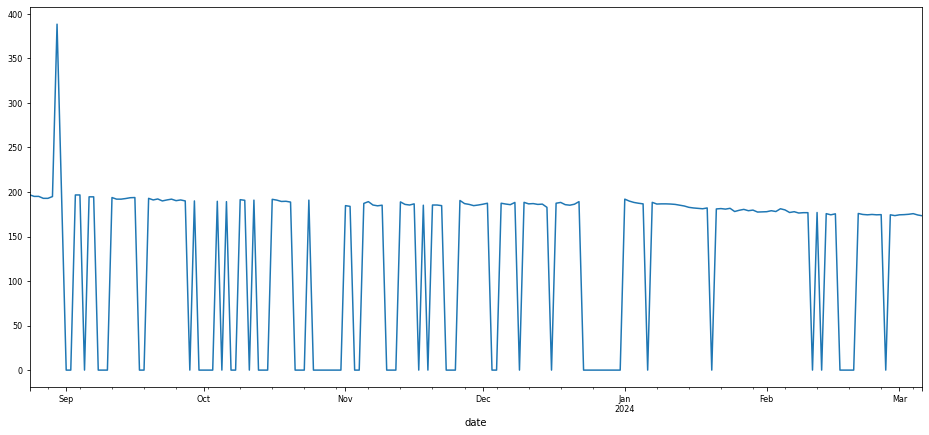

In [2705]:
import matplotlib.pyplot as plt
%matplotlib inline

df['BodyMass_lb'].plot(figsize = (16,7));
plt.show()

In [2706]:
null_weights = len(df[df['BodyMass_lb'] < 100])
total = len(df['BodyMass_lb'])
null_weights/total

0.3163265306122449

We have a few issues to resolve. The biggest issue is the number of zero entries. Based on our knowledge of human weight fluctation, we know it's impossible to weight 0 pounds. More than likely, these are the dates when a wiegh-in was never performed. We should convert these values to NaN to make our graph appear better.

In [2707]:
#import numpy as np
#df[df['BodyMass_lb'] == 0]['BodyMass_lb'] = np.NaN 
#df['BodyMass_lb'].replace(0.0,np.NaN)
df.loc[df['BodyMass_lb'] == 0.0,'BodyMass_lb'] = np.nan

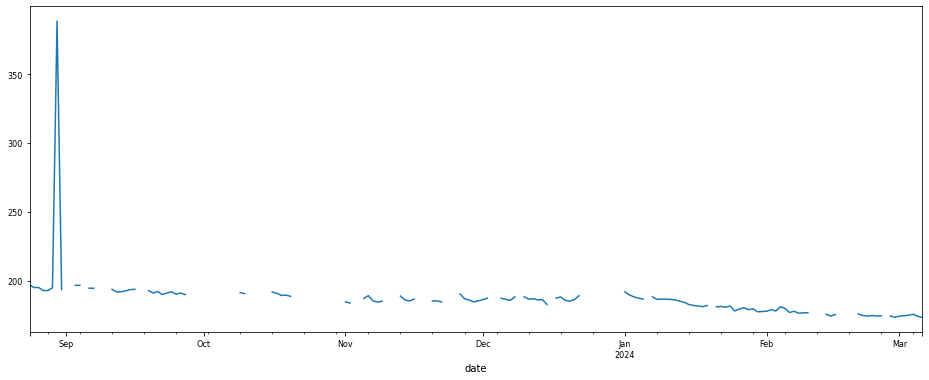

In [2708]:
df['BodyMass_lb'].plot(figsize = (16,6));
plt.show()

In [2709]:
df.loc[df['BodyMass_lb'] == 388.5,'BodyMass_lb'] = np.nan

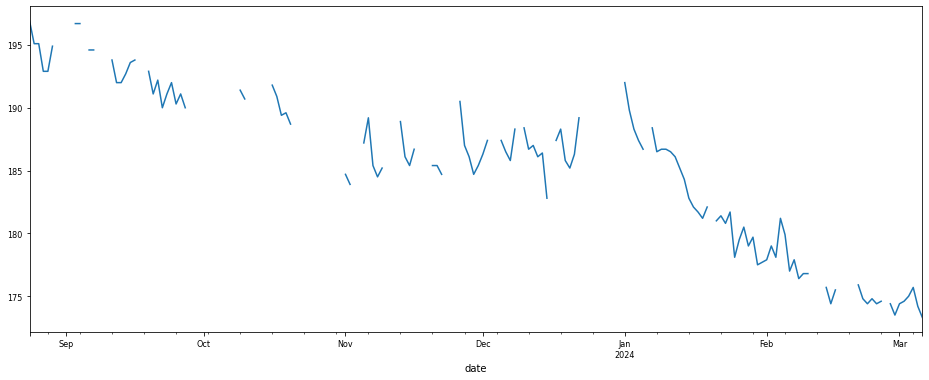

In [2710]:
df['BodyMass_lb'].plot(figsize = (16,6));
plt.show()

This confirms that we don't have much data related to weight prior to late August. When we go into startdate, it might be prudent to consider Aug. 24th as the actual start date. I'm going to modify the data so there's nothing prior

### Important Column inspection - Sleep

In [2711]:
col_sleep = ['SleepAnalysis_AsleepDeep_hrs', 'SleepAnalysis_AsleepCore_hrs', 'SleepAnalysis_AsleepREM_hrs', 'SleepAnalysis_Awake_hrs', 'AppleExerciseTime_min']

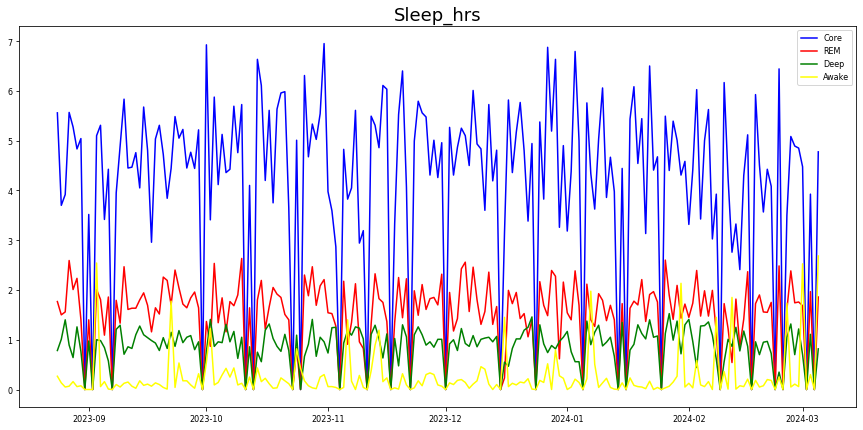

In [2712]:
plt.rcParams['figure.figsize']=(15,7)

plt.plot(df['SleepAnalysis_AsleepCore_hrs'], color='blue', label = 'Core')
plt.plot(df['SleepAnalysis_AsleepREM_hrs'], color='red', label = 'REM')
plt.plot(df['SleepAnalysis_AsleepDeep_hrs'], color='green', label = 'Deep')
plt.plot(df['SleepAnalysis_Awake_hrs'], color='yellow', label = 'Awake')
 
plt.title('Sleep_hrs')
plt.legend()
plt.show()

In [2713]:
df['SleepAnalysis_AsleepDeep_hrs'].replace(to_replace=0,value = df['SleepAnalysis_AsleepDeep_hrs'].mean(), inplace = True)
df['SleepAnalysis_AsleepCore_hrs'].replace(to_replace=0,value = df['SleepAnalysis_AsleepCore_hrs'].mean(), inplace = True)
df['SleepAnalysis_AsleepREM_hrs'].replace(to_replace=0,value = df['SleepAnalysis_AsleepREM_hrs'].mean(), inplace = True)
df['SleepAnalysis_Awake_hrs'].replace(to_replace=0,value = df['SleepAnalysis_Awake_hrs'].mean(), inplace = True)

In [2714]:
df

,BodyMass_lb,StepCount_count,DistanceWalkingRunning_mi,BasalEnergyBurned_Cal,ActiveEnergyBurned_Cal,FlightsClimbed_count,DietaryFatTotal_g,DietaryFatPolyunsaturated_g,DietaryFatMonounsaturated_g,DietaryFatSaturated_g,...,DietarySelenium_mcg,DietaryCopper_mg,DietaryManganese_mg,DietaryPotassium_mg,AppleExerciseTime_min,SleepAnalysis_AsleepDeep_hrs,SleepAnalysis_AsleepCore_hrs,SleepAnalysis_AsleepREM_hrs,SleepAnalysis_Awake_hrs,day
date,,,,,,,,,,,,,,,,,,,,,
2023-08-24,196.9,8895.0,4.163569,2055.322,564.7780,24.0,159.7455,11.8,9.5,36.2203,...,9.0,0.3,1.1,1572.0,12.0,0.783333,5.558333,1.766667,0.266667,Thursday
2023-08-25,195.1,9276.0,4.512434,2174.950,793.3800,7.0,62.9275,0.0,0.0,10.8165,...,0.0,0.0,0.0,0.0,36.0,1.008333,3.700000,1.500000,0.133333,Friday
2023-08-26,195.1,10883.0,4.948209,2074.476,395.3870,9.0,118.3000,8.3,15.0,39.5000,...,13.0,0.5,0.8,1943.0,8.0,1.400000,3.916667,1.558333,0.050000,Saturday
2023-08-27,192.9,19174.0,9.909258,2187.383,895.4360,14.0,79.9300,3.1,2.9,27.9600,...,18.0,0.3,0.5,1986.0,45.0,0.891667,5.566667,2.591667,0.066667,Sunday
2023-08-28,192.9,13636.0,6.833914,2186.244,901.5490,21.0,70.8500,4.6,7.1,16.3000,...,17.0,0.3,0.9,455.0,43.0,0.641667,5.275000,2.008333,0.158333,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-02,174.6,13416.0,6.533640,2048.925,1651.9890,16.0,76.2000,2.4,3.0,25.0000,...,24.0,0.3,1.4,1996.0,148.0,0.863462,4.172222,1.510000,0.252308,Saturday
2024-03-03,175.0,15876.0,7.722016,2048.189,1443.2150,22.0,59.9000,1.3,0.6,9.7000,...,51.0,0.4,3.2,1987.0,173.0,1.108333,3.925000,1.966667,0.300000,Sunday
2024-03-04,175.7,8191.0,4.051709,1983.933,499.0720,4.0,87.7000,7.9,9.9,25.9000,...,58.0,0.3,2.8,1023.0,76.0,0.863462,4.172222,1.510000,0.252308,Monday


In [2715]:
df[col_sleep] = df[col_sleep].fillna(df[col_sleep].mean())

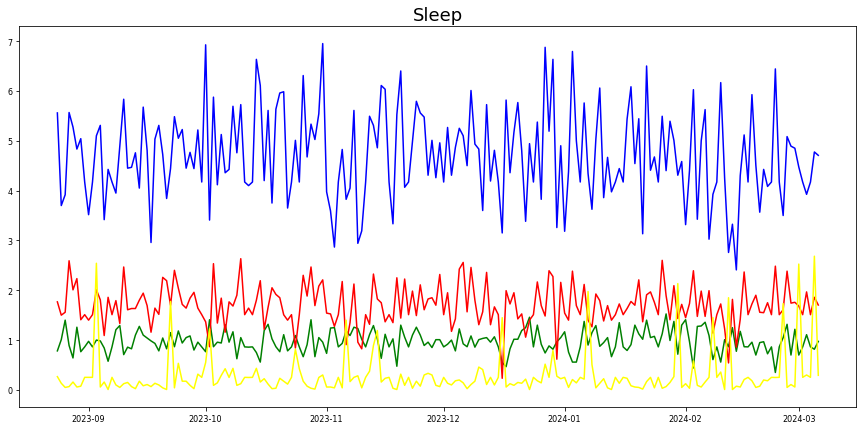

In [2716]:
plt.rcParams['figure.figsize']=(15,7)

plt.plot(df['SleepAnalysis_AsleepDeep_hrs'], color='green')
plt.plot(df['SleepAnalysis_AsleepCore_hrs'], color='blue')
plt.plot(df['SleepAnalysis_AsleepREM_hrs'], color='red')
plt.plot(df['SleepAnalysis_Awake_hrs'], color='yellow')
 
plt.title('Sleep')
plt.show()

### Important Column inspection - Exercise

In [2717]:
col_exercise = ['StepCount_count', 'DistanceWalkingRunning_mi', 'BasalEnergyBurned_Cal', 'ActiveEnergyBurned_Cal', 'FlightsClimbed_count']

In [2718]:
df.drop(['StepCount_count', 'DistanceWalkingRunning_mi', 'FlightsClimbed_count'], axis = 1, inplace = True)

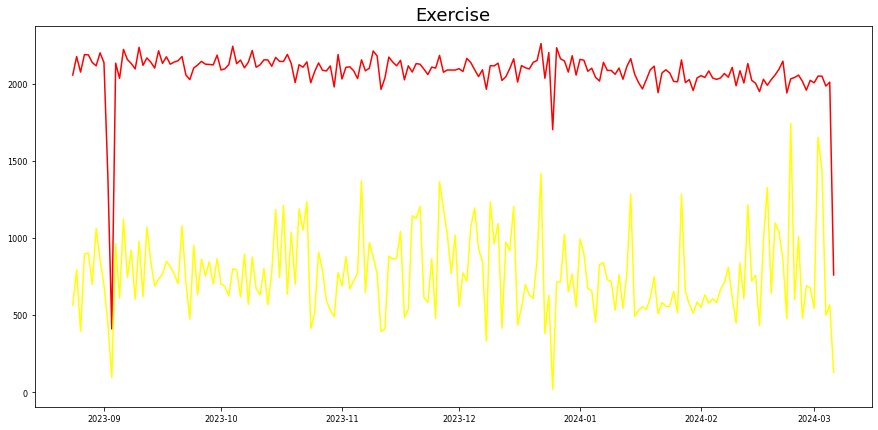

In [2719]:
plt.rcParams['figure.figsize']=(15,7)

#plt.plot(df['StepCount_count'], color='green')
#plt.plot(df['DistanceWalkingRunning_mi'], color='blue')
plt.plot(df['BasalEnergyBurned_Cal'], color='red')
plt.plot(df['ActiveEnergyBurned_Cal'], color='yellow')
#plt.plot(df['FlightsClimbed_count'], color='yellow')
 
plt.title('Exercise')
plt.show()

In [2720]:
#Cond_act = df['ActiveEnergyBurned_Cal'] < 250
#bas_act = df['BasalEnergyBurned_Cal'] < 250

df.loc[df['ActiveEnergyBurned_Cal'] < 250, 'ActiveEnergyBurned_Cal'] = df['ActiveEnergyBurned_Cal'].mean()
df.loc[df['BasalEnergyBurned_Cal'] < 1750, 'BasalEnergyBurned_Cal'] = df['BasalEnergyBurned_Cal'].mean()


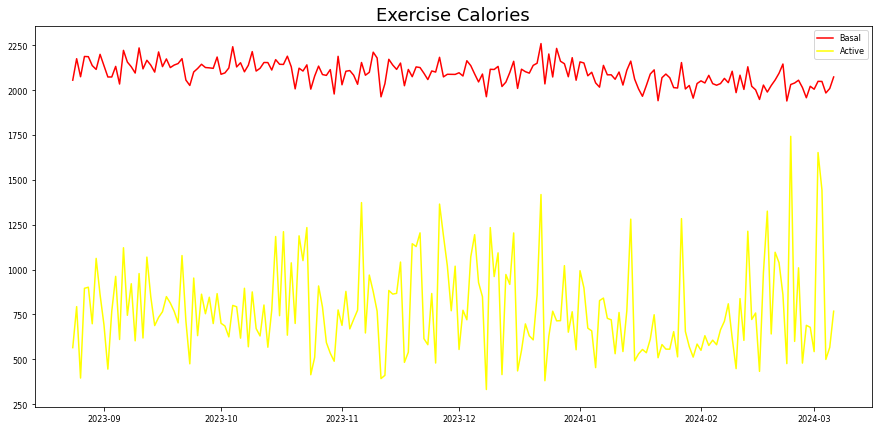

In [2721]:
plt.rcParams['figure.figsize']=(15,7)

#plt.plot(df['StepCount_count'], color='green')
#plt.plot(df['DistanceWalkingRunning_mi'], color='blue')
plt.plot(df['BasalEnergyBurned_Cal'], color='red', label = 'Basal')
plt.plot(df['ActiveEnergyBurned_Cal'], color='yellow', label = 'Active')
#plt.plot(df['FlightsClimbed_count'], color='yellow')
 
plt.title('Exercise Calories')
plt.legend()
plt.show()

### Important Column inspection - Dietary

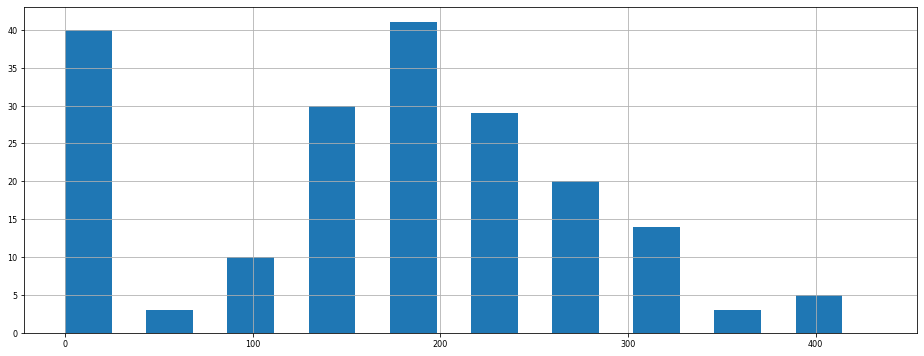

In [2722]:
df['DietaryCarbohydrates_g'].hist(figsize = (16,6), width = 25);
plt.show()

In [2723]:
null_carbs = len(df[df['DietaryCarbohydrates_g'] == 0])
null_carbs/total

0.18877551020408162

OKay, so we have considerable 0 values here. 

Missing at Random (MAR): Data points are missing depending on observed values in other variables, but not on the missing values themselves. This is a more complex scenario, but imputation using observed data can still be effective.

After doing some previewing, I'm determining that those 3 data points, whose carbs are under 75g, are also incomplete. So this isn't just the carbohydrate data, but all of the dietary information. So, we'll set all of the dietary information to Nan where the daily carbohydrates are less than 75g.


In [2724]:
#we'll go ahead and limit the 
Nan_cond = df['DietaryCarbohydrates_g'] < 75.0

col_dietary = [col for col in df.columns if "Dietary" in col]
df.loc[df['DietaryCarbohydrates_g'] < 75.0, col_dietary] = np.nan


#df.loc[df['DietaryCarbohydrates_g'] < 75.0,'DietaryCarbohydrates_g'] = np.nan

In [2725]:
df.loc['2023-08-29':'2023-09-04','DietaryFatTotal_g':'DietaryProtein_g']

,DietaryFatTotal_g,DietaryFatPolyunsaturated_g,DietaryFatMonounsaturated_g,DietaryFatSaturated_g,DietaryCholesterol_mg,DietarySodium_mg,DietaryCarbohydrates_g,DietaryFiber_g,DietarySugar_g,DietaryEnergyConsumed_Cal,DietaryProtein_g
date,,,,,,,,,,,
2023-08-29,144.7,7.2,9.5,31.79,1020.0,5397.5,252.36,23.63,57.04,3275.0,320.99
2023-08-30,109.6,19.8,24.2,27.10,323.0,2111.0,153.80,14.80,58.50,1983.0,99.50
2023-08-31,53.5,4.8,7.4,16.70,317.0,3635.0,129.60,14.70,32.90,1635.0,87.90
2023-09-01,150.7,11.7,36.7,54.40,748.0,4619.0,424.20,28.00,116.20,3767.0,98.70
2023-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-04,102.3,4.7,21.4,29.80,62.0,2549.0,260.20,21.50,41.60,2627.0,45.90


Let's figure out which columns we want to keep.

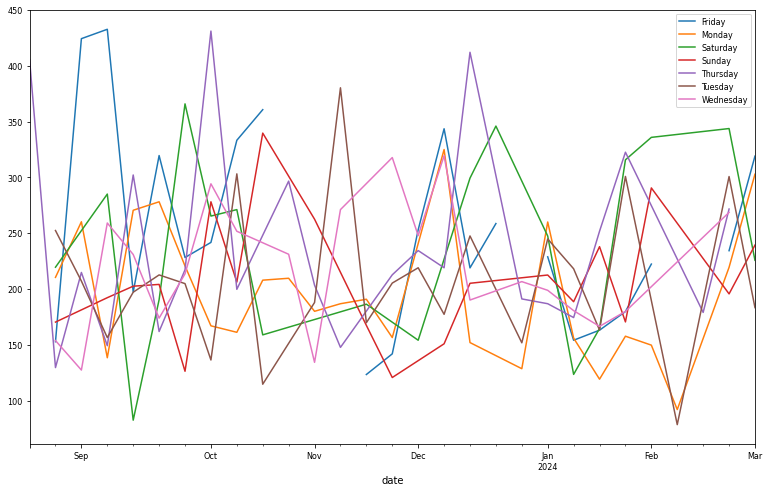

In [2726]:
#let's plot our carbohydrates
df.groupby(['day'])['DietaryCarbohydrates_g'].plot(figsize = (13,8), subplots=False, legend=True);
plt.show()

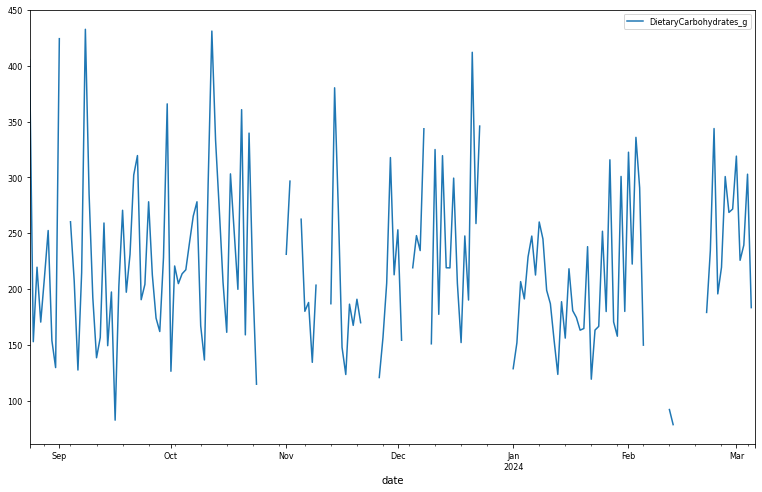

In [2727]:
#let's plot our carbohydrates
df['DietaryCarbohydrates_g'].plot(figsize = (13,8), subplots=False, legend=True);
plt.show()

okay, so we have some gaps to fill, let's start with filling in some 

Let's look at our null data

In [2728]:
nul_carbs = pd.isnull(df['DietaryCarbohydrates_g'])
df[nul_carbs]['DietaryCarbohydrates_g']

date
2023-09-02   NaN
2023-09-03   NaN
2023-10-25   NaN
2023-10-26   NaN
2023-10-27   NaN
2023-10-28   NaN
2023-10-29   NaN
2023-10-31   NaN
2023-11-03   NaN
2023-11-04   NaN
2023-11-10   NaN
2023-11-11   NaN
2023-11-12   NaN
2023-11-22   NaN
2023-11-23   NaN
2023-11-25   NaN
2023-12-03   NaN
2023-12-04   NaN
2023-12-09   NaN
2023-12-24   NaN
2023-12-25   NaN
2023-12-26   NaN
2023-12-27   NaN
2023-12-28   NaN
2023-12-29   NaN
2023-12-30   NaN
2023-12-31   NaN
2024-02-06   NaN
2024-02-07   NaN
2024-02-08   NaN
2024-02-09   NaN
2024-02-10   NaN
2024-02-11   NaN
2024-02-14   NaN
2024-02-15   NaN
2024-02-16   NaN
2024-02-17   NaN
2024-02-18   NaN
2024-02-19   NaN
2024-02-20   NaN
2024-02-21   NaN
2024-03-06   NaN
Name: DietaryCarbohydrates_g, dtype: float64

A quick scan here shows that we have chunks of time series data missing. The best way to handle this, in my opion, is to divide into two subsets, to disregard those stretches of missing data.

These chunks will be (8-23: 10-24), (10-31: 12-23), (1-01: 02-05), (02-22: 03-05). These were chunks of data were determined by finding "chunks" of both null and valid data. Chunks of valid data were determined to have no more than 3 consecutive days of null data. To fill these in, let's start create the chunks

In [2729]:
SepOct = df['2023-08-23':'2023-10-24']
NovDec = df['2023-10-31':'2023-12-23']
Jan = df['2024-01-01':'2024-02-05']
FebMar = df['2024-02-24':'2024-03-05']

okay, now let's fill in the null values with the mean for all of the dietary nulls here.

In [2730]:
df[col_dietary] = df[col_dietary].fillna(df[col_dietary].mean())

Okay so this looks promising. We see a little flattening of the curve, but, it doesn't mess with our data too much. Let's go ahead and create this for all of our data, in Sept, Oct

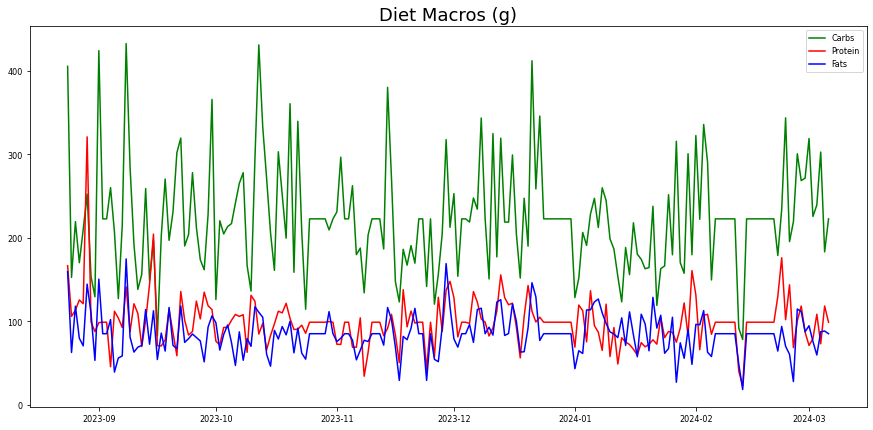

In [2731]:
plt.rcParams['figure.figsize']=(15,7)

plt.plot(df['DietaryCarbohydrates_g'], color='green', label = 'Carbs')
plt.plot(df['DietaryProtein_g'], color='red', label = 'Protein')
plt.plot(df['DietaryFatTotal_g'], color='blue', label = 'Fats')
 
plt.title('Diet Macros (g)')
plt.legend()
plt.show()

### Focusing on Weight
What we really care about is weight, and the difference of weight.

#### Test for Stationality
First, let's use a Dickey-Fuller Test on our data to see if we have Stationality. We're going to use the Dickey-Fuller test in the stats model. This function does not permit null values. And, we have some null values, so we'll have to fill in missing data. To do this, we'll need to utilize a certain level of synthetic data. For starters, let's just first look at our data. 

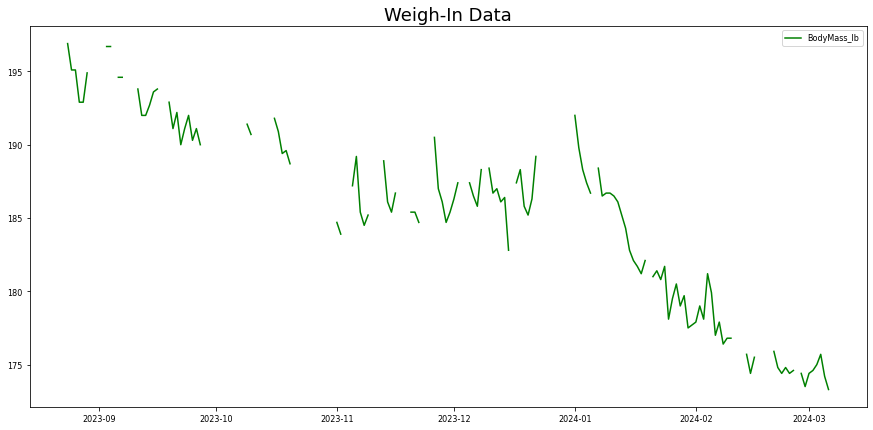

In [2732]:
plt.rcParams['figure.figsize']=(15,7)

plt.plot(df['BodyMass_lb'], color='green', label = 'BodyMass_lb')
 
plt.title('Weigh-In Data')
plt.legend()
plt.show()

In [2733]:
df['BodyMass_lb_inter'] = df['BodyMass_lb'].interpolate(option='spline')

In [2734]:
import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

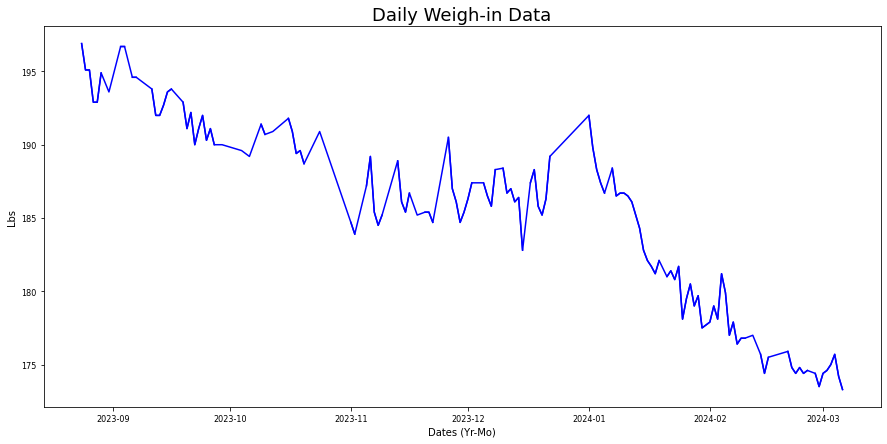

In [2735]:
import matplotlib

plt.rcParams['figure.figsize']=(15,7)

plt.plot(df['BodyMass_lb_inter'], color='blue', label = 'Interpolated_Data')
plt.plot(df['BodyMass_lb'], color='blue', label = 'Actual')

#plt.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%b"))

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 18

plt.rc('axes', titlesize=SMALL_SIZE, labelsize=MEDIUM_SIZE)

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
#plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#matplotlib.rc('font', size=BIGGER_SIZE)
#matplotlib.rc('axes', titlesize=BIGGER_SIZE)

plt.title('Daily Weigh-in Data')
plt.xlabel('Dates (Yr-Mo)')
plt.ylabel('Lbs')
#plt.legend()
plt.show()

In [2736]:
#initialize a blank series series without the date index
series = df['BodyMass_lb_inter'].reset_index()

#loop through series and move the interpolated weight one index (data) up
for ind in range(0,len(series)-1):
    series.loc[ind, 'BodyMass_lb_inter'] = series.loc[ind+1, 'BodyMass_lb_inter']

#make the last value Nan    
series.loc[ind+1, 'BodyMass_lb_inter'] = np.NaN

#re-stablish date index
series.set_index('date', inplace = True)

#create new feature in df to represent the new lagged body mass
df['BodyMass_lb_inter'] = series['BodyMass_lb_inter']

In [2737]:
df

,BodyMass_lb,BasalEnergyBurned_Cal,ActiveEnergyBurned_Cal,DietaryFatTotal_g,DietaryFatPolyunsaturated_g,DietaryFatMonounsaturated_g,DietaryFatSaturated_g,DietaryCholesterol_mg,DietarySodium_mg,DietaryCarbohydrates_g,...,DietaryCopper_mg,DietaryManganese_mg,DietaryPotassium_mg,AppleExerciseTime_min,SleepAnalysis_AsleepDeep_hrs,SleepAnalysis_AsleepCore_hrs,SleepAnalysis_AsleepREM_hrs,SleepAnalysis_Awake_hrs,day,BodyMass_lb_inter
date,,,,,,,,,,,,,,,,,,,,,
2023-08-24,196.9,2055.322000,564.778000,159.745500,11.800000,9.500000,36.22030,565.69000,8798.470000,405.441300,...,0.300000,1.100000,1572.000000,12.0,0.783333,5.558333,1.766667,0.266667,Thursday,195.1
2023-08-25,195.1,2174.950000,793.380000,62.927500,0.000000,0.000000,10.81650,296.60000,3860.600000,152.775000,...,0.000000,0.000000,0.000000,36.0,1.008333,3.700000,1.500000,0.133333,Friday,195.1
2023-08-26,195.1,2074.476000,395.387000,118.300000,8.300000,15.000000,39.50000,380.00000,4585.000000,219.500000,...,0.500000,0.800000,1943.000000,8.0,1.400000,3.916667,1.558333,0.050000,Saturday,192.9
2023-08-27,192.9,2187.383000,895.436000,79.930000,3.100000,2.900000,27.96000,320.00000,6119.000000,170.340000,...,0.300000,0.500000,1986.000000,45.0,0.891667,5.566667,2.591667,0.066667,Sunday,192.9
2023-08-28,192.9,2186.244000,901.549000,70.850000,4.600000,7.100000,16.30000,375.00000,5591.000000,210.400000,...,0.300000,0.900000,455.000000,43.0,0.641667,5.275000,2.008333,0.158333,Monday,194.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-02,174.6,2048.925000,1651.989000,76.200000,2.400000,3.000000,25.00000,182.00000,4885.000000,225.700000,...,0.300000,1.400000,1996.000000,148.0,0.863462,4.172222,1.510000,0.252308,Saturday,175.0
2024-03-03,175.0,2048.189000,1443.215000,59.900000,1.300000,0.600000,9.70000,289.00000,3056.000000,239.300000,...,0.400000,3.200000,1987.000000,173.0,1.108333,3.925000,1.966667,0.300000,Sunday,175.7
2024-03-04,175.7,1983.933000,499.072000,87.700000,7.900000,9.900000,25.90000,293.00000,2816.000000,302.800000,...,0.300000,2.800000,1023.000000,76.0,0.863462,4.172222,1.510000,0.252308,Monday,174.2


In [2738]:
#let's create the weight difference in a new column
df['BodyMass_lb_diff'] = df['BodyMass_lb_inter'].diff() 

In [2739]:
#provide the first differenced entry
df.iloc[0,len(df.columns)-1] = df.iloc[0,len(df.columns)-2] - df.iloc[0,0]

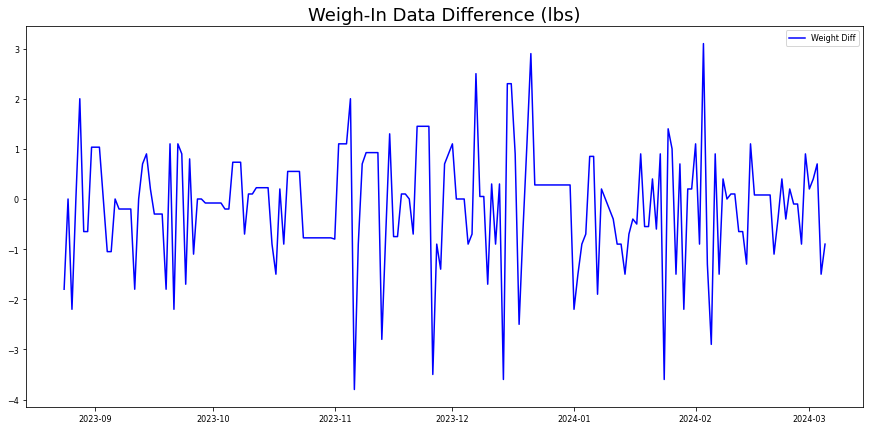

In [2740]:
plt.rcParams['figure.figsize']=(15,7)

plt.plot(df['BodyMass_lb_diff'], color='blue', label = 'Weight Diff')

plt.title('Weigh-In Data Difference (lbs)')
plt.legend()
plt.show()

In [2741]:
new_df = df.dropna(subset=['BodyMass_lb_diff'])

In [2742]:
#SepOct = df['2023-08-23': '2023-10-24']
#NovDec = df['2023-10-31': '2023-12-23']
#Jan = df['2024-01-01': '2024-02-05']
#FebMar = df['2024-02-24': '2024-03-05']

#new_df = pd.concat([SepOct, NovDec, Jan, FebMar])


In [2743]:
new_df

,BodyMass_lb,BasalEnergyBurned_Cal,ActiveEnergyBurned_Cal,DietaryFatTotal_g,DietaryFatPolyunsaturated_g,DietaryFatMonounsaturated_g,DietaryFatSaturated_g,DietaryCholesterol_mg,DietarySodium_mg,DietaryCarbohydrates_g,...,DietaryManganese_mg,DietaryPotassium_mg,AppleExerciseTime_min,SleepAnalysis_AsleepDeep_hrs,SleepAnalysis_AsleepCore_hrs,SleepAnalysis_AsleepREM_hrs,SleepAnalysis_Awake_hrs,day,BodyMass_lb_inter,BodyMass_lb_diff
date,,,,,,,,,,,,,,,,,,,,,
2023-08-24,196.9,2055.322,564.7780,159.7455,11.8,9.5,36.2203,565.69,8798.47,405.4413,...,1.1,1572.0,12.0,0.783333,5.558333,1.766667,0.266667,Thursday,195.1,-1.8
2023-08-25,195.1,2174.950,793.3800,62.9275,0.0,0.0,10.8165,296.60,3860.60,152.7750,...,0.0,0.0,36.0,1.008333,3.700000,1.500000,0.133333,Friday,195.1,0.0
2023-08-26,195.1,2074.476,395.3870,118.3000,8.3,15.0,39.5000,380.00,4585.00,219.5000,...,0.8,1943.0,8.0,1.400000,3.916667,1.558333,0.050000,Saturday,192.9,-2.2
2023-08-27,192.9,2187.383,895.4360,79.9300,3.1,2.9,27.9600,320.00,6119.00,170.3400,...,0.5,1986.0,45.0,0.891667,5.566667,2.591667,0.066667,Sunday,192.9,0.0
2023-08-28,192.9,2186.244,901.5490,70.8500,4.6,7.1,16.3000,375.00,5591.00,210.4000,...,0.9,455.0,43.0,0.641667,5.275000,2.008333,0.158333,Monday,194.9,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01,174.4,2004.932,542.6680,94.9000,5.6,10.7,22.2000,152.00,4231.00,319.0000,...,3.3,2447.0,12.0,0.700000,4.475000,1.683333,2.525000,Friday,174.6,0.2
2024-03-02,174.6,2048.925,1651.9890,76.2000,2.4,3.0,25.0000,182.00,4885.00,225.7000,...,1.4,1996.0,148.0,0.863462,4.172222,1.510000,0.252308,Saturday,175.0,0.4
2024-03-03,175.0,2048.189,1443.2150,59.9000,1.3,0.6,9.7000,289.00,3056.00,239.3000,...,3.2,1987.0,173.0,1.108333,3.925000,1.966667,0.300000,Sunday,175.7,0.7


In [2744]:
new_df['BodyMass_lb_diff'].isna().sum()

0

Now that we have differenced the data, and have nothing null, let's go ahead and test for Dickey-Fuller

In [2745]:
dftest = adfuller(new_df['BodyMass_lb_diff'])

In [2746]:
 # Print Dickey-Fuller test results
print('Results of Dickey-Fuller Test: \n')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)
    

Results of Dickey-Fuller Test: 

Test Statistic                -9.581410e+00
p-value                        2.153488e-16
#Lags Used                     3.000000e+00
Number of Observations Used    1.910000e+02
Critical Value (1%)           -3.465059e+00
Critical Value (5%)           -2.876794e+00
Critical Value (10%)          -2.574901e+00
dtype: float64


This looks good. The differenced data appears stationary. Let's see how the decomposed time looks.

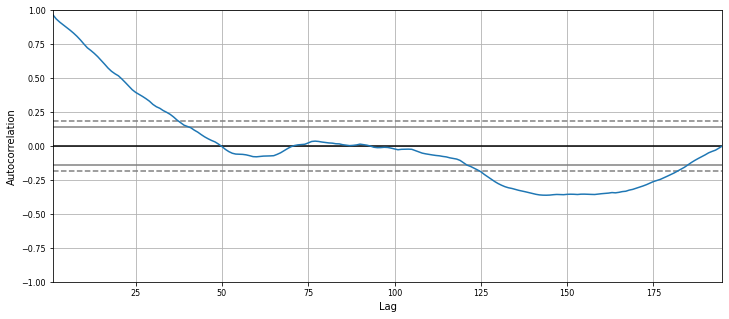

In [2747]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(new_df['BodyMass_lb_inter']);


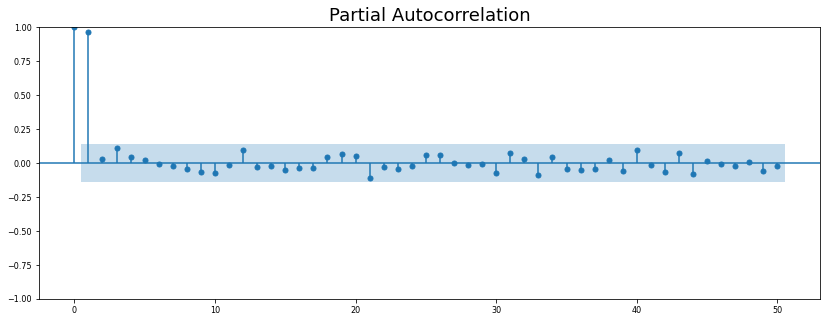

In [2748]:
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5

plot_pacf(new_df['BodyMass_lb_inter'], lags=50);

Both plots look pretty stationary. So that's great. Also, both plots trail off with time. This is a good sign that these functions are a good candidate for AutoRegressive (AR) and Moving Average (MA) Analysis

#### ARMA Analysis
We've confirmed our data is stationary. We observed the PACF And ACF plots and understood that both trail off wtih time. This means our weigh-in data is a good candidate for both AR and MA. To do this. We're going to utilize our original weigh-in data. There's plenty of missing data, but luckily our ARIMA works with missing data. We also no that 1st order differencing made our data stationary, so we can jump straight to that when we check for ARMA.

In [2749]:
new_df['BodyMass_lb_inter'].isna().sum()

0

In [2750]:
# split into train and test sets. Let's do an 80/20 split
#SepOct = new_df['2023-08-25': '2023-10-24']
#NovDec = new_df['2023-10-31': '2023-12-23']
#Jan = new_df['2024-01-01': '2024-02-05']
#FebMar = new_df['2024-02-24': '2024-03-05']

train = new_df['2023-08-25': '2023-12-23']['BodyMass_lb_inter']
test = new_df['2023-12-24': '2024-03-05']['BodyMass_lb_inter']

train_len = len(train)
test_len = len(test)

# walk-forward validation


In [2751]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [2752]:
from pmdarima import auto_arima

model = auto_arima(new_df['BodyMass_lb_inter'], seasonal=False, m=0, stepwise=True)

# Get the best ARIMA model
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  195
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -294.205
Date:                Fri, 07 Jun 2024   AIC                            596.410
Time:                        09:30:11   BIC                            609.482
Sample:                    08-24-2023   HQIC                           601.703
                         - 03-05-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0366      0.020     -1.787      0.074      -0.077       0.004
ar.L1          0.6675      0.149      4.486      0.000       0.376       0.959
ma.L1         -0.8107      0.125     -6.461      0.0

So... we run the auto and we find the most accurate ARIMA arrangement, which is 1st order lagged on both the moving average and the autoregressed term. This makes sense - we already determined that the differenced data was stationary, and it appears that we also care about both AR and MA. To run the auto, we had to use some synthetic data, but we can also utilize a manual check. We can also check the interpolated data and the actual data.

In [2753]:
# Import ARIMA
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

# Instantiate an AR(1) model to the simulated data
mod_arma_raw = ARIMA(new_df['BodyMass_lb_inter'], order=(1,1,1))

C:\Users\benne\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benne\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benne\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [2754]:
# Fit the model to data
res_arma_raw = mod_arma_raw.fit()

C:\Users\benne\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\benne\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [2755]:
# Print out summary information on the fit
print(res_arma_raw.summary())

                               SARIMAX Results                                
Dep. Variable:      BodyMass_lb_inter   No. Observations:                  195
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -296.540
Date:                Fri, 07 Jun 2024   AIC                            599.080
Time:                        09:30:12   BIC                            608.884
Sample:                    08-24-2023   HQIC                           603.050
                         - 03-05-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6205      0.237      2.623      0.009       0.157       1.084
ma.L1         -0.7385      0.215     -3.439      0.001      -1.159      -0.318
sigma2         1.2448      0.108     11.539      0.0

So it appears we got a significantly more accurate model, which also dropped out the Y-intercept term. We also have statistically significant

In [2756]:
# Instantiate an MA(1) model to the simulated data
mod_arma_inter = ARIMA(new_df['BodyMass_lb_inter'], order=(1,1,1))

# Fit the model to data
res_arma_inter = mod_arma_inter.fit()

# Print out summary information on the fit
print(res_arma_inter.summary())

                               SARIMAX Results                                
Dep. Variable:      BodyMass_lb_inter   No. Observations:                  195
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -296.540
Date:                Fri, 07 Jun 2024   AIC                            599.080
Time:                        09:30:12   BIC                            608.884
Sample:                    08-24-2023   HQIC                           603.050
                         - 03-05-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6205      0.237      2.623      0.009       0.157       1.084
ma.L1         -0.7385      0.215     -3.439      0.001      -1.159      -0.318
sigma2         1.2448      0.108     11.539      0.0

C:\Users\benne\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benne\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benne\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benne\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\benne\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\

Interesting. On our first check with got an AIC/BIC in the high 400s, but coefficients with high high statistical confidence. This was using the raw, uninterpolated data. Let's see how this look with the interpolated data.

In [2757]:
arma_raw_resid = pd.Series(res_arma_raw.resid)
arma_raw_resid.drop('2023-08-24', axis = 0, inplace = True)

arma_inter_resid = pd.Series(res_arma_inter.resid)
arma_inter_resid.drop('2023-08-24', axis = 0, inplace = True)

In [2758]:
arma_inter_resid

date
2023-08-25    0.000025
2023-08-26   -2.199982
2023-08-27   -0.240141
2023-08-28    1.823800
2023-08-29   -0.548919
                ...   
2024-03-01    0.204629
2024-03-02    0.427012
2024-03-03    0.767136
2024-03-04   -1.367841
2024-03-05   -0.979352
Length: 194, dtype: float64

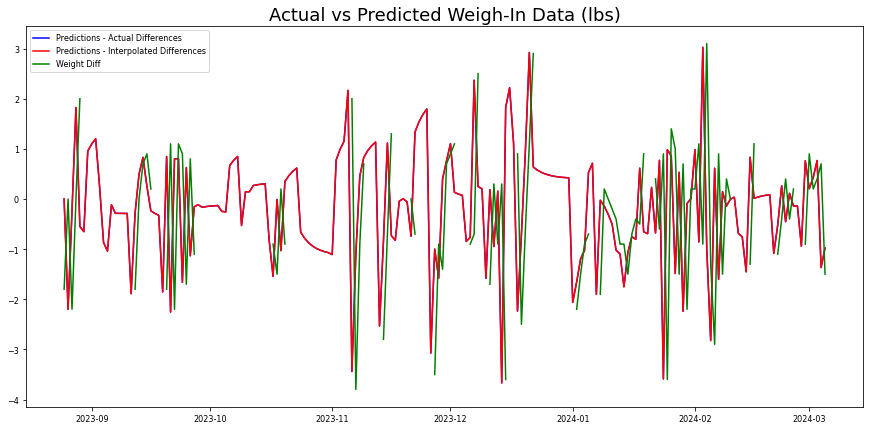

In [2759]:
plt.rcParams['figure.figsize']=(15,7)

plt.plot(arma_raw_resid, color='blue', label = 'Predictions - Actual Differences')
plt.plot(arma_inter_resid, color='red', label = 'Predictions - Interpolated Differences')
plt.plot(new_df['BodyMass_lb'].diff(), color='green', label = 'Weight Diff')

plt.title('Actual vs Predicted Weigh-In Data (lbs)')
plt.legend()
plt.show()

In [2760]:
arma_inter_resid.mean()

-0.15949596976660105

So... we can see that the predictions with interpolated differences, do a good job of sticking to the general peaks. We don't visually see much of a drop off in accuracy, even though our model tells us otherwise. I'm inclined to utilize the residuals from the interpolated data as our error.

But what does this mean about our weight data?  It means that are both enourages and fights whatever weight difference we experienced? It's almost as if a part of our metabolism wants to continue a trend and another part is trying to course correct. Anecdotally, there are stories about how really in shape super athletes will metablolize excess carbs/fat as opposed to storing them as fat. It's almost if the body knows our behavior, and wants to continue it. Why store fat on an athlete that is in burn mode. Let's just store as glycogen or, get rid of it. On the one hand, the course correction side, perhaps there's a mechanism in our body that's continually trying to use/store/release all of the calolories that are body consumes. Perhaps as very finite corrections. As if the body says, "Well, I thought I was going to burn X amount of calories, but I only burned Y. So tomorrow, I'll slow down and metabolize less." The course correction could also swing the other way - if too much weight gain, the body could metabolize more.

But how does that account for weight loss. That's where our trend of moving average comes in (also, the drift in the random walk model). Herein lies a conundrum, our original weight difference numbers passed the test for stationality, but there is a slight trend in the data (-.12). This is approximately 0.12 lbs per day that, on average, of weight loss. It's small enough to not throw off stationality, yet large enough to lose more than 15 lbs in 6 months.

Okay, so, back to our diet information. We have two separate errors now from which we can predict some noise. First we have our original weight loss change from day to day. Second, we have the residuals from our ARMA model with which it predict. So... let's do it.

### Feature Engineering

So, now that we added have scrubbed our data. We're going to create a few different target variables, all in the name of weight loss. The first, will be just the difference of our weight loss from day to day. The second, will be the residuals from our predicted

In [2761]:
#let's separate our target and feature columns.
#df['diff_inter'] = arma_inter_resid
df['BodyMass_lb_raw'] = df['BodyMass_lb']

df.drop('BodyMass_lb', axis = 1, inplace = True)
df.drop('day', axis = 1, inplace = True)

Let's move the interpolated weight up an index. Let's also drop our Nans on the last row

In [2762]:
#drop NAs from the last row
df = df.dropna(subset=['BodyMass_lb_diff'])

We can also use this time to make a category to determine if weight loss occurred. This is relatively simple. Let's call it weight loss, and we'll give it a 1, if there's was weight loss, and 0 if there wasn't. In this scenario, even 0 lbs would be the same as weight gain.

In [2763]:
df['weight_loss'] = df['BodyMass_lb_diff'] < 0.01
df['weight_loss'] = df['weight_loss'].astype(int)

<ipython-input-2763-09b7dd648cc7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weight_loss'] = df['BodyMass_lb_diff'] < 0.01
<ipython-input-2763-09b7dd648cc7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weight_loss'] = df['weight_loss'].astype(int)


In [2764]:
weight_days = pd.DataFrame(df[df['weight_loss'] == 1]['weight_loss'].resample('M').count())
weight_days['weight_gain'] = df[df['weight_loss'] == 0]['weight_loss'].resample('M').count()
weight_days.reset_index(inplace = True)

In [2765]:
#weight_days['date'] = weight_days['date'].dt.month
weight_days['date'] = weight_days['date'].dt.month_name().str[:3]

In [2766]:
weight_days.set_index('date', inplace = True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'Aug'),
  Text(1, 0, 'Sep'),
  Text(2, 0, 'Oct'),
  Text(3, 0, 'Nov'),
  Text(4, 0, 'Dec'),
  Text(5, 0, 'Jan'),
  Text(6, 0, 'Feb'),
  Text(7, 0, 'Mar')])

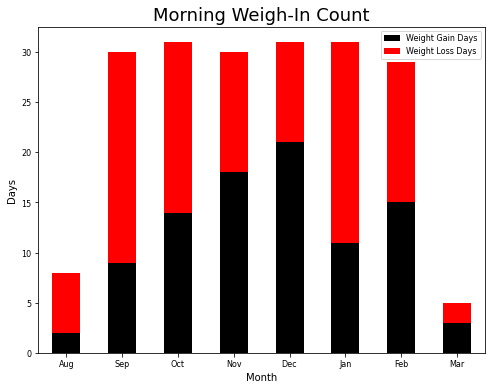

In [2767]:
fig, ax = plt.subplots(figsize=(8,6))

ax = weight_days['weight_gain'].plot.bar(color='black', label = 'Weight Gain Days')
ax = weight_days['weight_loss'].plot.bar(bottom = weight_days['weight_gain'], color ='red', label = 'Weight Loss Days')

ax.set_title('Morning Weigh-In Count')
ax.set_xlabel('Month')
ax.set_ylabel('Days')
ax.legend()
plt.xticks(rotation=None)

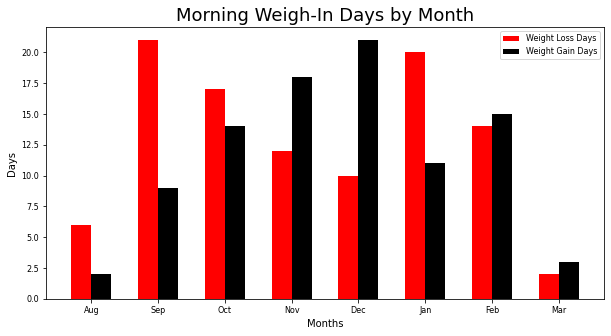

In [2768]:
# Specify the values of blue bars (height)
weight_gain = weight_days['weight_gain']

# Specify the values of orange bars (height)
weight_loss = weight_days['weight_loss']

# Position of bars on x-axis
ind = np.arange(len(weight_days['weight_gain']))

# Figure size
plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.3       

# Plotting
plt.bar(ind, weight_loss, width, label='Weight Loss Days', color = 'red')
plt.bar(ind + width, weight_gain, width, label='Weight Gain Days', color = 'black')

plt.xlabel('Months')
plt.ylabel('Days')
plt.title('Morning Weigh-In Days by Month')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width/2, weight_days.index)

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.show()

In [2769]:
weight_days.loc['totals'] = [weight_days['weight_loss'].sum(), weight_days['weight_gain'].sum()]
weight_days

,weight_loss,weight_gain
date,,
Aug,6,2
Sep,21,9
Oct,17,14
Nov,12,18
Dec,10,21
Jan,20,11
Feb,14,15
Mar,2,3
totals,102,93


### PCA
Now that we have all of these feature variables, and we believe we're in good shape. Let's figure out

In [2770]:
df

,BasalEnergyBurned_Cal,ActiveEnergyBurned_Cal,DietaryFatTotal_g,DietaryFatPolyunsaturated_g,DietaryFatMonounsaturated_g,DietaryFatSaturated_g,DietaryCholesterol_mg,DietarySodium_mg,DietaryCarbohydrates_g,DietaryFiber_g,...,DietaryPotassium_mg,AppleExerciseTime_min,SleepAnalysis_AsleepDeep_hrs,SleepAnalysis_AsleepCore_hrs,SleepAnalysis_AsleepREM_hrs,SleepAnalysis_Awake_hrs,BodyMass_lb_inter,BodyMass_lb_diff,BodyMass_lb_raw,weight_loss
date,,,,,,,,,,,,,,,,,,,,,
2023-08-24,2055.322,564.7780,159.7455,11.8,9.5,36.2203,565.69,8798.47,405.4413,50.7511,...,1572.0,12.0,0.783333,5.558333,1.766667,0.266667,195.1,-1.8,196.9,1
2023-08-25,2174.950,793.3800,62.9275,0.0,0.0,10.8165,296.60,3860.60,152.7750,19.1820,...,0.0,36.0,1.008333,3.700000,1.500000,0.133333,195.1,0.0,195.1,1
2023-08-26,2074.476,395.3870,118.3000,8.3,15.0,39.5000,380.00,4585.00,219.5000,14.8000,...,1943.0,8.0,1.400000,3.916667,1.558333,0.050000,192.9,-2.2,195.1,1
2023-08-27,2187.383,895.4360,79.9300,3.1,2.9,27.9600,320.00,6119.00,170.3400,43.0200,...,1986.0,45.0,0.891667,5.566667,2.591667,0.066667,192.9,0.0,192.9,1
2023-08-28,2186.244,901.5490,70.8500,4.6,7.1,16.3000,375.00,5591.00,210.4000,26.4000,...,455.0,43.0,0.641667,5.275000,2.008333,0.158333,194.9,2.0,192.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01,2004.932,542.6680,94.9000,5.6,10.7,22.2000,152.00,4231.00,319.0000,34.5000,...,2447.0,12.0,0.700000,4.475000,1.683333,2.525000,174.6,0.2,174.4,0
2024-03-02,2048.925,1651.9890,76.2000,2.4,3.0,25.0000,182.00,4885.00,225.7000,23.6000,...,1996.0,148.0,0.863462,4.172222,1.510000,0.252308,175.0,0.4,174.6,0
2024-03-03,2048.189,1443.2150,59.9000,1.3,0.6,9.7000,289.00,3056.00,239.3000,17.5000,...,1987.0,173.0,1.108333,3.925000,1.966667,0.300000,175.7,0.7,175.0,0


In [2771]:
targets = df.loc[:,'BodyMass_lb_inter':'weight_loss']
features = df.loc[:,'BasalEnergyBurned_Cal':'SleepAnalysis_Awake_hrs']

In [2772]:
targets['BodyMass_lb_diff']

date
2023-08-24   -1.8
2023-08-25    0.0
2023-08-26   -2.2
2023-08-27    0.0
2023-08-28    2.0
             ... 
2024-03-01    0.2
2024-03-02    0.4
2024-03-03    0.7
2024-03-04   -1.5
2024-03-05   -0.9
Name: BodyMass_lb_diff, Length: 195, dtype: float64

Whoa! That is pretty good. In fact, it's really where there's no data do we see these big gaps

In [2773]:
from sklearn.preprocessing import MinMaxScaler

scaler_minmax = MinMaxScaler() 
features_minmax = scaler_minmax.fit_transform(features)

In [2774]:
from sklearn.preprocessing import StandardScaler

scaler_std = StandardScaler() 
features_std = pd.DataFrame(scaler_std.fit_transform(features), columns = features.columns)

In [2775]:
# Your code here
#import seaborn as sns
corr_check = features_std.corr()
corr_check

,BasalEnergyBurned_Cal,ActiveEnergyBurned_Cal,DietaryFatTotal_g,DietaryFatPolyunsaturated_g,DietaryFatMonounsaturated_g,DietaryFatSaturated_g,DietaryCholesterol_mg,DietarySodium_mg,DietaryCarbohydrates_g,DietaryFiber_g,...,DietaryZinc_mg,DietarySelenium_mcg,DietaryCopper_mg,DietaryManganese_mg,DietaryPotassium_mg,AppleExerciseTime_min,SleepAnalysis_AsleepDeep_hrs,SleepAnalysis_AsleepCore_hrs,SleepAnalysis_AsleepREM_hrs,SleepAnalysis_Awake_hrs
BasalEnergyBurned_Cal,1.000000,0.427528,-0.079405,0.004440,0.031884,0.107261,0.081708,-0.086660,-0.082343,-0.142552,...,0.109326,-0.047975,0.049579,-0.034707,-0.133811,0.171318,0.009437,-0.052136,-0.038240,-0.171630
ActiveEnergyBurned_Cal,0.427528,1.000000,-0.184262,-0.038984,-0.103592,-0.029447,0.010805,-0.113352,-0.038510,-0.156212,...,0.061402,-0.036507,0.100241,0.155286,-0.073848,0.727649,-0.067533,-0.013823,0.046233,-0.052601
DietaryFatTotal_g,-0.079405,-0.184262,1.000000,0.409662,0.538561,0.766857,0.392124,0.468713,0.518573,0.367222,...,0.174413,-0.014860,0.181878,-0.099507,0.127158,-0.103241,-0.013732,0.027744,0.032411,-0.005045
DietaryFatPolyunsaturated_g,0.004440,-0.038984,0.409662,1.000000,0.759861,0.270351,0.103494,0.112963,0.298685,0.057802,...,0.373954,0.241562,0.250433,0.234579,0.094129,-0.053794,-0.082238,0.094793,0.102132,-0.087458
DietaryFatMonounsaturated_g,0.031884,-0.103592,0.538561,0.759861,1.000000,0.416619,0.140721,0.004734,0.289783,0.091621,...,0.479946,0.227206,0.335338,0.102532,0.149828,-0.092053,-0.008011,0.152550,0.108278,-0.067028
DietaryFatSaturated_g,0.107261,-0.029447,0.766857,0.270351,0.416619,1.000000,0.499474,0.406751,0.549303,0.105869,...,0.336274,0.123328,0.240232,-0.080752,-0.002499,-0.019518,-0.000196,0.003233,0.018290,-0.023446
DietaryCholesterol_mg,0.081708,0.010805,0.392124,0.103494,0.140721,0.499474,1.000000,0.437794,0.226833,-0.087209,...,0.285822,0.135355,-0.009223,-0.133082,0.114322,0.076572,-0.086608,0.060539,0.073845,0.033133
DietarySodium_mg,-0.086660,-0.113352,0.468713,0.112963,0.004734,0.406751,0.437794,1.000000,0.444894,0.396475,...,0.090512,0.020222,0.045291,-0.098828,0.165913,-0.062016,-0.030261,0.041758,0.136302,-0.065591
DietaryCarbohydrates_g,-0.082343,-0.038510,0.518573,0.298685,0.289783,0.549303,0.226833,0.444894,1.000000,0.410418,...,0.245143,0.045311,0.321905,0.303764,0.075157,-0.012312,-0.012369,-0.073185,0.002471,0.075066
DietaryFiber_g,-0.142552,-0.156212,0.367222,0.057802,0.091621,0.105869,-0.087209,0.396475,0.410418,1.000000,...,-0.024112,-0.180279,0.283842,0.188523,0.285243,-0.078651,0.081322,-0.048705,0.072633,0.024875


In [2776]:
#let's try to analyze the PCA's here
from sklearn.decomposition import PCA

pca_1 = PCA(n_components=12)
pca_2 = PCA(n_components=24)
pca_3 = PCA(n_components=36)

principalComponents = pca_1.fit_transform(features_std)
principalComponents = pca_2.fit_transform(features_std)
principalComponents = pca_3.fit_transform(features_std)

print(np.sum(pca_1.explained_variance_ratio_))
print(np.sum(pca_2.explained_variance_ratio_))
print(np.sum(pca_3.explained_variance_ratio_))


0.7872874527781722
0.9507601639451543
0.9956855811815972


Wow, okay, so we can maintain about 80% of our data through 12 components, down from 45. At the same time, a lot of correlation (the heat in our correlation map). It's probably a good time to delve into the data a bit more. Previously, we divided our data into dietary, exercise, and sleep. It turns out, we may need to create further subsets. Let's start with dietary. 

For dietary information, it's useful to think of it in levels. It starts with Level 1 - `DietaryEnergyConsumed_Cal`, from there we go to Level 2 - macronutrients  `DietaryFatTotals_g`, `DietaryCarbohydrates_g`, `DietaryProtein_g`. But fortunately for us, we have, what I call, Level 3 - sub-macronutrients still measured in grams, which includes things like `DietarySugar_g` which is a carbohydrate, and `DietarySaturatedFats_g` which is a fat. Going further, we have micronutrients, or Level 4 - measured in milligrams (or even micrograms) of things like `DietarySodium_mg` and `DietaryCholesterol_mg`.

Same with sleep. With sleep, we have level 2 data - REM, Core, Deep. We also have awake hours as well. Level 1 data, if we wanted it, would consist of the total hours of sleep we got. So, if we chose to include only Level 1 diet data in our analysis, it might be better to be consistent with sleep as well. Same with exercise. We have basal and active calories, or Level 2, and we have exercise minutes. Exercise minutes are even a collary category of workout. 

There's a big correlative overlap between Level 1, 2, & 3. So, we have to make a decision on what we want to include. Given where we are, let's start with Level 1 and go from there.

To do that, let's create these categories of sub-data. For sleep, we'll have to feature engineer to add it.

In [2777]:
#let's add totals for sleep and energy burned
df['SleepAnalysis_AsleepTotal_hrs'] = df['SleepAnalysis_AsleepDeep_hrs'] + df['SleepAnalysis_AsleepCore_hrs'] + df['SleepAnalysis_AsleepREM_hrs']
df['TotalEnergyBurned_Cal'] = df['BasalEnergyBurned_Cal'] + df['ActiveEnergyBurned_Cal']


<ipython-input-2777-0a91160b6859>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SleepAnalysis_AsleepTotal_hrs'] = df['SleepAnalysis_AsleepDeep_hrs'] + df['SleepAnalysis_AsleepCore_hrs'] + df['SleepAnalysis_AsleepREM_hrs']
<ipython-input-2777-0a91160b6859>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalEnergyBurned_Cal'] = df['BasalEnergyBurned_Cal'] + df['ActiveEnergyBurned_Cal']


In [2778]:
#combine all 3 - Level 1 
level_1 = ['DietaryEnergyConsumed_Cal', 'TotalEnergyBurned_Cal', 'SleepAnalysis_AsleepTotal_hrs']
level_1_diet = ['DietaryEnergyConsumed_Cal']
level_1_exer = ['TotalEnergyBurned_Cal']
level_1_sleep = ['SleepAnalysis_AsleepTotal_hrs']

feature_1 = df[level_1]

In [2779]:
feature_1.corr()

,DietaryEnergyConsumed_Cal,TotalEnergyBurned_Cal,SleepAnalysis_AsleepTotal_hrs
DietaryEnergyConsumed_Cal,1.000000,-0.110698,-0.033527
TotalEnergyBurned_Cal,-0.110698,1.000000,-0.018068
SleepAnalysis_AsleepTotal_hrs,-0.033527,-0.018068,1.000000


In [2780]:
#combine - Level 2
level_2_diet = ['DietaryFatTotal_g', 'DietaryProtein_g', 'DietaryCarbohydrates_g']
level_2_exer = ['BasalEnergyBurned_Cal','ActiveEnergyBurned_Cal']
level_2_sleep = ['SleepAnalysis_AsleepDeep_hrs','SleepAnalysis_AsleepCore_hrs','SleepAnalysis_AsleepREM_hrs', 'SleepAnalysis_Awake_hrs']
level_2 = level_2_diet + level_2_exer + level_2_sleep
feature_2 = df[level_2]

In [2781]:
df[level_2_diet].corr()

,DietaryFatTotal_g,DietaryProtein_g,DietaryCarbohydrates_g
DietaryFatTotal_g,1.000000,0.370709,0.518573
DietaryProtein_g,0.370709,1.000000,0.234538
DietaryCarbohydrates_g,0.518573,0.234538,1.000000


In [2782]:
df[level_2_exer].corr()

,BasalEnergyBurned_Cal,ActiveEnergyBurned_Cal
BasalEnergyBurned_Cal,1.000000,0.427528
ActiveEnergyBurned_Cal,0.427528,1.000000


In [2783]:
#feature engineering - let's create some of the categories for dietary 3
df['DietaryCarbsResidual_g'] = df['DietaryCarbohydrates_g'] - df['DietarySugar_g'] - df['DietaryFiber_g'] 
df['DietaryFatsResidual_g'] = df['DietaryFatTotal_g'] - df['DietaryFatMonounsaturated_g'] -  df['DietaryFatPolyunsaturated_g'] - df['DietaryFatSaturated_g'] 

#let's aggregate the level 3 dietary information
level_3_diet_carbs = ['DietaryCarbsResidual_g', 'DietarySugar_g', 'DietaryFiber_g']
level_3_diet_fat = ['DietaryFatsResidual_g', 'DietaryFatMonounsaturated_g', 'DietaryFatPolyunsaturated_g', 'DietaryFatSaturated_g']
level_3_diet_protein = ['DietaryProtein_g']
level_3_diet = level_3_diet_carbs + level_3_diet_fat + level_3_diet_protein

#combine - Level 3, please note, there is no level 3 for sleep and exercise, we will reuse level 2 info there
level_3 = level_3_diet + level_2_exer + level_2_sleep
feature_3 = df[level_3]

<ipython-input-2783-b850bfcb1b01>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DietaryCarbsResidual_g'] = df['DietaryCarbohydrates_g'] - df['DietarySugar_g'] - df['DietaryFiber_g']
<ipython-input-2783-b850bfcb1b01>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DietaryFatsResidual_g'] = df['DietaryFatTotal_g'] - df['DietaryFatMonounsaturated_g'] -  df['DietaryFatPolyunsaturated_g'] - df['DietaryFatSaturated_g']


In [2784]:
df[level_3_diet].corr()

,DietaryCarbsResidual_g,DietarySugar_g,DietaryFiber_g,DietaryFatsResidual_g,DietaryFatMonounsaturated_g,DietaryFatPolyunsaturated_g,DietaryFatSaturated_g,DietaryProtein_g
DietaryCarbsResidual_g,1.000000,0.255375,0.215990,-0.011805,0.338847,0.368133,0.374811,0.202577
DietarySugar_g,0.255375,1.000000,0.305928,0.344598,0.059736,0.039081,0.584568,0.148848
DietaryFiber_g,0.215990,0.305928,1.000000,0.423675,0.091621,0.057802,0.105869,0.155146
DietaryFatsResidual_g,-0.011805,0.344598,0.423675,1.000000,-0.219835,-0.273606,0.226343,0.336410
DietaryFatMonounsaturated_g,0.338847,0.059736,0.091621,-0.219835,1.000000,0.759861,0.416619,0.006005
DietaryFatPolyunsaturated_g,0.368133,0.039081,0.057802,-0.273606,0.759861,1.000000,0.270351,0.085007
DietaryFatSaturated_g,0.374811,0.584568,0.105869,0.226343,0.416619,0.270351,1.000000,0.310872
DietaryProtein_g,0.202577,0.148848,0.155146,0.336410,0.006005,0.085007,0.310872,1.000000


In [2785]:
#now, let's scale the data and redo or correlation matrix, will use both minmax and standard for reference
scaler_minmax = MinMaxScaler() 
feature_1_minmax = pd.DataFrame(scaler_minmax.fit_transform(feature_1), columns = feature_1.columns)
feature_1_minmax['date'] = targets['BodyMass_lb_diff'].index
feature_1_minmax = feature_1_minmax.set_index('date')

scaler_std = StandardScaler() 
feature_1_std = pd.DataFrame(scaler_std.fit_transform(feature_1), columns = feature_1.columns)
feature_1_std['date'] = targets['BodyMass_lb_diff'].index
feature_1_std = feature_1_std.set_index('date')


In [2786]:
#import seaborn as sns
feature_1_std.corr()

,DietaryEnergyConsumed_Cal,TotalEnergyBurned_Cal,SleepAnalysis_AsleepTotal_hrs
DietaryEnergyConsumed_Cal,1.000000,-0.110698,-0.033527
TotalEnergyBurned_Cal,-0.110698,1.000000,-0.018068
SleepAnalysis_AsleepTotal_hrs,-0.033527,-0.018068,1.000000


In [2787]:
scaler_std = StandardScaler() 
feature_2_std = pd.DataFrame(scaler_std.fit_transform(feature_2), columns = feature_2.columns)
feature_2_std['date'] = targets['BodyMass_lb_diff'].index
feature_2_std = feature_2_std.set_index('date')

In [2788]:
feature_2_std.corr()

,DietaryFatTotal_g,DietaryProtein_g,DietaryCarbohydrates_g,BasalEnergyBurned_Cal,ActiveEnergyBurned_Cal,SleepAnalysis_AsleepDeep_hrs,SleepAnalysis_AsleepCore_hrs,SleepAnalysis_AsleepREM_hrs,SleepAnalysis_Awake_hrs
DietaryFatTotal_g,1.000000,0.370709,0.518573,-0.079405,-0.184262,-0.013732,0.027744,0.032411,-0.005045
DietaryProtein_g,0.370709,1.000000,0.234538,0.026628,-0.100561,0.022191,0.042303,0.136812,-0.094609
DietaryCarbohydrates_g,0.518573,0.234538,1.000000,-0.082343,-0.038510,-0.012369,-0.073185,0.002471,0.075066
BasalEnergyBurned_Cal,-0.079405,0.026628,-0.082343,1.000000,0.427528,0.009437,-0.052136,-0.038240,-0.171630
ActiveEnergyBurned_Cal,-0.184262,-0.100561,-0.038510,0.427528,1.000000,-0.067533,-0.013823,0.046233,-0.052601
SleepAnalysis_AsleepDeep_hrs,-0.013732,0.022191,-0.012369,0.009437,-0.067533,1.000000,-0.138032,-0.031208,-0.106168
SleepAnalysis_AsleepCore_hrs,0.027744,0.042303,-0.073185,-0.052136,-0.013823,-0.138032,1.000000,0.568832,-0.085293
SleepAnalysis_AsleepREM_hrs,0.032411,0.136812,0.002471,-0.038240,0.046233,-0.031208,0.568832,1.000000,-0.210226
SleepAnalysis_Awake_hrs,-0.005045,-0.094609,0.075066,-0.171630,-0.052601,-0.106168,-0.085293,-0.210226,1.000000


Okay, so we solved our correlation and components problem... simply by applying domain knowledge and feature engineering. Now, we can run some analysis here.

So... which analysis should we use first. The solution is obvious... linear regression. Before we dive in, we should be aware of something in our protocol. The weigh-ins occurred every morning, first thing. They are recorded as weight's for that day. But, much like sleep, the weight recorded that morning is really a reflection of the previous days activities. Or, put it this way, the weight recorded on, say, October 17th as nothing to do with the food, exercise, and sleep on October 17th. As their shown in the data, they're linked. It's more accurate to show the weigh-in occuring on October 17th as the result of behaviors on October 16th. We'll make a new column called "Lagged Weight"

### LINEAR REGRESSION

In [2789]:
#specify X and Y, remembering to drop the last entry as
X = feature_1_std
y = targets['BodyMass_lb_diff']

In [2790]:
#create model
level_1_model = sm.OLS(y, sm.add_constant(X))
level_1_results = level_1_model.fit()

#print results
print(level_1_results.summary())

                            OLS Regression Results                            
Dep. Variable:       BodyMass_lb_diff   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     8.349
Date:                Fri, 07 Jun 2024   Prob (F-statistic):           3.03e-05
Time:                        09:30:17   Log-Likelihood:                -287.87
No. Observations:                 195   AIC:                             583.7
Df Residuals:                     191   BIC:                             596.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [2791]:
feature_1_rolling_2 = feature_1.rolling(2).sum().drop(['2023-08-24'], axis = 0)
y.drop('2023-08-24', axis = 0, inplace = True)

In [2792]:
#specify X and Y, remembering to drop the first entry as
X = feature_1_rolling_2

#create model
level_1_model_minmax = sm.OLS(y, sm.add_constant(X))
level_1__minmax_results = level_1_model_minmax.fit()

#print results
print(level_1__minmax_results.summary())

                            OLS Regression Results                            
Dep. Variable:       BodyMass_lb_diff   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     6.970
Date:                Fri, 07 Jun 2024   Prob (F-statistic):           0.000179
Time:                        09:30:17   Log-Likelihood:                -287.60
No. Observations:                 194   AIC:                             583.2
Df Residuals:                     190   BIC:                             596.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

Okay, or model got worse! We have a slightly higher AIC/BIC, we have one moving average variable (basically 0). And non of our coefficients are statistically significant.

In [2793]:
feature_1_rolling_3 = feature_1.rolling(3).sum().drop(['2023-08-24', '2023-08-25'], axis = 0)
y.drop('2023-08-25', axis = 0,inplace = True)

In [2794]:
#specify X and Y, remembering to drop the first entry as
X = feature_1_rolling_3

#create model
level_1_model_minmax = sm.OLS(y, sm.add_constant(X))
level_1__minmax_results = level_1_model_minmax.fit()

#print results
print(level_1__minmax_results.summary())

                            OLS Regression Results                            
Dep. Variable:       BodyMass_lb_diff   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     5.059
Date:                Fri, 07 Jun 2024   Prob (F-statistic):            0.00216
Time:                        09:30:17   Log-Likelihood:                -289.24
No. Observations:                 193   AIC:                             586.5
Df Residuals:                     189   BIC:                             599.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

### Linear Regression with Deep Learning

In [2795]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [2796]:
pip install tensorflow_addons

Note: you may need to restart the kernel to use updated packages.


In [2797]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(feature_1, targets['BodyMass_lb_diff'], random_state = 243, test_size = .25)

# Split the data
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, random_state = 243, test_size = .25)

In [2798]:
# Import StandardScaler
from sklearn.preprocessing import StandardScaler

# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train_final)
scaled_data_val = scaler.fit_transform(X_val)

In [2799]:
model_1 = Sequential()

#we'll start with 10 neurons, and an input shape of 14
model_1.add(Dense(12, activation='linear', input_shape=(3,)))
model_1.add(Dense(8, activation='linear'))
model_1.add(Dense(4, activation='linear'))

#output classification layer
model_1.add(Dense(1, activation='linear'))

In [2800]:
from keras import optimizers
from tensorflow_addons.metrics import RSquare
# Compile the model
#metric = keras.metrics.R2Score()
model_1.compile(loss='mse', optimizer=optimizers.RMSprop(learning_rate=0.001), metrics=['accuracy'])

In [2801]:
#fit model
results_1  = model_1.fit(scaled_data_train,
                   y_train_final,
                    epochs=100,
                    validation_data=(scaled_data_val, y_val))

Epoch 1/100
4/4 [==============================] - 2s 90ms/step - loss: 2.0026 - accuracy: 0.0550 - val_loss: 1.9861 - val_accuracy: 0.0811
Epoch 2/100
4/4 [==============================] - 0s 16ms/step - loss: 1.7465 - accuracy: 0.0550 - val_loss: 1.7979 - val_accuracy: 0.0811
Epoch 3/100
4/4 [==============================] - 0s 22ms/step - loss: 1.6011 - accuracy: 0.0642 - val_loss: 1.6884 - val_accuracy: 0.0811
Epoch 4/100
4/4 [==============================] - 0s 24ms/step - loss: 1.5174 - accuracy: 0.0642 - val_loss: 1.5936 - val_accuracy: 0.0811
Epoch 5/100
4/4 [==============================] - 0s 21ms/step - loss: 1.4415 - accuracy: 0.0642 - val_loss: 1.5143 - val_accuracy: 0.0811
Epoch 6/100
4/4 [==============================] - 0s 22ms/step - loss: 1.3751 - accuracy: 0.0642 - val_loss: 1.4492 - val_accuracy: 0.0811
Epoch 7/100
4/4 [==============================] - 0s 21ms/step - loss: 1.3276 - accuracy: 0.0642 - val_loss: 1.3793 - val_accuracy: 0.0811
Epoch 8/100
4/4 [===

4/4 [==============================] - 0s 20ms/step - loss: 1.0683 - accuracy: 0.0642 - val_loss: 0.9720 - val_accuracy: 0.0811
Epoch 60/100
4/4 [==============================] - 0s 16ms/step - loss: 1.0671 - accuracy: 0.0642 - val_loss: 0.9667 - val_accuracy: 0.0811
Epoch 61/100
4/4 [==============================] - 0s 15ms/step - loss: 1.0656 - accuracy: 0.0642 - val_loss: 0.9700 - val_accuracy: 0.0811
Epoch 62/100
4/4 [==============================] - 0s 17ms/step - loss: 1.0699 - accuracy: 0.0642 - val_loss: 0.9772 - val_accuracy: 0.0811
Epoch 63/100
4/4 [==============================] - 0s 14ms/step - loss: 1.0664 - accuracy: 0.0642 - val_loss: 0.9796 - val_accuracy: 0.0811
Epoch 64/100
4/4 [==============================] - 0s 13ms/step - loss: 1.0640 - accuracy: 0.0642 - val_loss: 0.9805 - val_accuracy: 0.0811
Epoch 65/100
4/4 [==============================] - 0s 14ms/step - loss: 1.0652 - accuracy: 0.0642 - val_loss: 0.9822 - val_accuracy: 0.0811
Epoch 66/100
4/4 [========

In [2802]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(feature_2, targets['BodyMass_lb_diff'], random_state = 243, test_size = .25)

# Split the data
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, random_state = 243, test_size = .25)

In [2803]:
# Import StandardScaler
from sklearn.preprocessing import StandardScaler

# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train_final)
scaled_data_val = scaler.fit_transform(X_val)

In [2804]:
model_1 = Sequential()

#we'll start with 10 neurons, and an input shape of 9
model_1.add(Dense(12, activation='linear', input_shape=(9,)))
model_1.add(Dense(8, activation='linear'))
model_1.add(Dense(4, activation='linear'))

#output classification layer
model_1.add(Dense(1, activation='linear'))

In [2805]:
model_1.compile(loss='mse', optimizer='rmsprop', metrics=[RSquare()])

In [2806]:
#fit model
results_1  = model_1.fit(scaled_data_train,
                   y_train_final,
                    epochs=100,
                    validation_data=(scaled_data_val, y_val))

Epoch 1/100
4/4 [==============================] - 5s 123ms/step - loss: 3.3808 - r_square: -1.8170 - val_loss: 1.4483 - val_r_square: -0.2668
Epoch 2/100
4/4 [==============================] - 0s 22ms/step - loss: 2.5092 - r_square: -1.0907 - val_loss: 1.2608 - val_r_square: -0.1028
Epoch 3/100
4/4 [==============================] - 0s 18ms/step - loss: 2.1009 - r_square: -0.7505 - val_loss: 1.1529 - val_r_square: -0.0084
Epoch 4/100
4/4 [==============================] - 0s 19ms/step - loss: 1.8413 - r_square: -0.5342 - val_loss: 1.0931 - val_r_square: 0.0439
Epoch 5/100
4/4 [==============================] - 0s 19ms/step - loss: 1.6500 - r_square: -0.3749 - val_loss: 1.0487 - val_r_square: 0.0827
Epoch 6/100
4/4 [==============================] - 0s 19ms/step - loss: 1.5164 - r_square: -0.2635 - val_loss: 1.0277 - val_r_square: 0.1011
Epoch 7/100
4/4 [==============================] - 0s 16ms/step - loss: 1.4054 - r_square: -0.1710 - val_loss: 1.0161 - val_r_square: 0.1112
Epoch 8/1

Epoch 59/100
4/4 [==============================] - 0s 17ms/step - loss: 0.9900 - r_square: 0.1751 - val_loss: 1.1888 - val_r_square: -0.0398
Epoch 60/100
4/4 [==============================] - 0s 17ms/step - loss: 0.9999 - r_square: 0.1668 - val_loss: 1.2005 - val_r_square: -0.0500
Epoch 61/100
4/4 [==============================] - 0s 32ms/step - loss: 0.9955 - r_square: 0.1705 - val_loss: 1.1773 - val_r_square: -0.0298
Epoch 62/100
4/4 [==============================] - 0s 18ms/step - loss: 0.9981 - r_square: 0.1684 - val_loss: 1.1789 - val_r_square: -0.0311
Epoch 63/100
4/4 [==============================] - 0s 16ms/step - loss: 0.9938 - r_square: 0.1719 - val_loss: 1.1789 - val_r_square: -0.0311
Epoch 64/100
4/4 [==============================] - 0s 14ms/step - loss: 0.9918 - r_square: 0.1736 - val_loss: 1.1744 - val_r_square: -0.0272
Epoch 65/100
4/4 [==============================] - 0s 14ms/step - loss: 1.0000 - r_square: 0.1667 - val_loss: 1.1602 - val_r_square: -0.0148
Epoch 

This seems to be getting worse. It may be that we don't have adequate data to determine a link with linear regression. Or, let's try testing using binary classification before we go further. We can use binary classification to use alternative

In [2807]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(feature_3, targets['BodyMass_lb_diff'], random_state = 243, test_size = .25)

# Split the data
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, random_state = 243, test_size = .25)

In [2808]:
# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train_final)
scaled_data_val = scaler.fit_transform(X_val)

In [2809]:
model_1 = Sequential()

#we'll start with 10 neurons, and an input shape of 14
model_1.add(Dense(12, activation='linear', input_shape=(14,)))
model_1.add(Dense(8, activation='linear'))
model_1.add(Dense(4, activation='linear'))

#output classification layer
model_1.add(Dense(1, activation='linear'))

In [2810]:
model_1.compile(loss='mse', optimizer=optimizers.RMSprop(learning_rate=0.001), metrics=['accuracy'])

In [2811]:
#fit model
results_1  = model_1.fit(scaled_data_train,
                   y_train_final,
                    epochs=100,
                    validation_data=(scaled_data_val, y_val))

Epoch 1/100
4/4 [==============================] - 1s 77ms/step - loss: 4.4378 - accuracy: 0.0550 - val_loss: 2.7405 - val_accuracy: 0.0541
Epoch 2/100
4/4 [==============================] - 0s 20ms/step - loss: 3.6375 - accuracy: 0.0550 - val_loss: 2.2486 - val_accuracy: 0.0541
Epoch 3/100
4/4 [==============================] - 0s 17ms/step - loss: 3.1409 - accuracy: 0.0550 - val_loss: 1.9649 - val_accuracy: 0.0541
Epoch 4/100
4/4 [==============================] - 0s 18ms/step - loss: 2.8316 - accuracy: 0.0550 - val_loss: 1.7859 - val_accuracy: 0.0541
Epoch 5/100
4/4 [==============================] - 0s 27ms/step - loss: 2.5995 - accuracy: 0.0642 - val_loss: 1.6321 - val_accuracy: 0.0541
Epoch 6/100
4/4 [==============================] - 0s 17ms/step - loss: 2.4051 - accuracy: 0.0642 - val_loss: 1.4985 - val_accuracy: 0.0541
Epoch 7/100
4/4 [==============================] - 0s 17ms/step - loss: 2.2448 - accuracy: 0.0642 - val_loss: 1.3722 - val_accuracy: 0.0541
Epoch 8/100
4/4 [===

4/4 [==============================] - 0s 16ms/step - loss: 0.9759 - accuracy: 0.0642 - val_loss: 1.1068 - val_accuracy: 0.0811
Epoch 60/100
4/4 [==============================] - 0s 15ms/step - loss: 0.9739 - accuracy: 0.0642 - val_loss: 1.1048 - val_accuracy: 0.0811
Epoch 61/100
4/4 [==============================] - 0s 16ms/step - loss: 0.9757 - accuracy: 0.0642 - val_loss: 1.1089 - val_accuracy: 0.0811
Epoch 62/100
4/4 [==============================] - 0s 15ms/step - loss: 0.9738 - accuracy: 0.0642 - val_loss: 1.1178 - val_accuracy: 0.0811
Epoch 63/100
4/4 [==============================] - 0s 15ms/step - loss: 0.9659 - accuracy: 0.0642 - val_loss: 1.1216 - val_accuracy: 0.0811
Epoch 64/100
4/4 [==============================] - 0s 16ms/step - loss: 0.9644 - accuracy: 0.0642 - val_loss: 1.1288 - val_accuracy: 0.0811
Epoch 65/100
4/4 [==============================] - 0s 14ms/step - loss: 0.9873 - accuracy: 0.0642 - val_loss: 1.1245 - val_accuracy: 0.0811
Epoch 66/100
4/4 [========

### Binomial Classification

### Baseline Model
As we mentioned earlier. Let's see what a model would produce, picking weight loss days at random.

In [2812]:
#import random module
import random

#initialize baseline dataframe from the weight loss column
baseline = pd.DataFrame(targets['weight_loss'])

#create a predictions column that randomly chooses 0 or 1
baseline['Predictions'] = np.random.randint(0,1,len(baseline))

#create another column which determines which are correct
baseline['Correct?'] = (baseline['weight_loss'] == baseline['Predictions'])

#count the true and false answers
baseline['Correct?'].value_counts(normalize=True)

Correct?
False    0.523077
True     0.476923
Name: proportion, dtype: float64

In [2813]:
aggs = df.groupby('weight_loss').agg(['mean', 'std'])
aggs

BasalEnergyBurned_Cal            ActiveEnergyBurned_Cal  \
                             mean        std                   mean   
weight_loss                                                           
0                     2085.135079  69.287741             751.561394   
1                     2101.654011  59.503110             803.008833   

                        DietaryFatTotal_g             \
                    std              mean        std   
weight_loss                                            
0            259.514675         89.787054  22.855447   
1            245.528494         81.348558  25.761411   

            DietaryFatPolyunsaturated_g           DietaryFatMonounsaturated_g  \
                                   mean       std                        mean   
weight_loss                                                                     
0                              8.837341  5.538187                   15.115640   
1                              7.050331  4.848816                   12.918245   

                       ... BodyMass_lb_raw            \
                  std  ...            mean       std   
weight_loss            ...                             
0            7.730691  ...      183.873214  6.040966   
1            9.285795  ...      186.413158  6.170410   

            SleepAnalysis_AsleepTotal_hrs           TotalEnergyBurned_Cal  \
                                     mean       std                  mean   
weight_loss                                                                 
0                                7.324480  1.221857           2836.696473   
1                                7.439939  1.160025           2904.662844   

                        DietaryCarbsResidual_g             \
                    std                   mean        std   
weight_loss                                                 
0            290.765121             161.517981  46.635794   
1            280.360873             137.324513  47.510769   

            DietaryFatsResidual_g             
                             mean        std  
weight_loss                                   
0                       40.970560  15.178598  
1                       41.218841  17.298612  

[2 rows x 96 columns]

Okay, that's not surprising. This is basically a 50-50 model (48%), with a few more weight_loss days than weight_gain days. Our model was about 48% accurate. Let 

### KNN Neighbors
So, let's run through some of the standard algorithms for each level of features.

#### Level 1 Features

In [2814]:
# Import train_test_split 
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(feature_1, df['weight_loss'], random_state = 42, test_size = .25)

In [2815]:
# Import StandardScaler
from sklearn.preprocessing import StandardScaler

# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.fit_transform(X_test)

# Convert into a DataFrame
scaled_df_train = pd.DataFrame(scaled_data_train, columns = feature_1.columns)

In [2816]:
# Import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

# Instantiate KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=11)

# Fit the classifier
clf.fit(scaled_data_train, y_train)

# Predict on the test set
test_preds = clf.predict(scaled_data_test)

In [2817]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# Complete the function
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))
    
print_metrics(y_test, test_preds)

Precision Score: 0.8095238095238095
Recall Score: 0.5666666666666667
Accuracy Score: 0.6530612244897959
F1 Score: 0.6666666666666666


In [2818]:
X_transformed = std.fit_transform(feature_1)

In [2819]:
scores_1 = cross_val_score(clf, X_transformed, df['weight_loss'], cv=10) #10 fold cross validation
scores_1.mean()

0.6263157894736842

So... Our level one cross-validated accuracy was 63%

### Level 2 Features

In [2820]:
# Import train_test_split 
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(feature_2, df['weight_loss'], random_state = 42, test_size = .25)

In [2821]:
X_train

,DietaryFatTotal_g,DietaryProtein_g,DietaryCarbohydrates_g,BasalEnergyBurned_Cal,ActiveEnergyBurned_Cal,SleepAnalysis_AsleepDeep_hrs,SleepAnalysis_AsleepCore_hrs,SleepAnalysis_AsleepREM_hrs,SleepAnalysis_Awake_hrs
date,,,,,,,,,
2023-10-28,85.373071,99.128901,222.833223,2082.017,593.098,1.408333,5.333333,2.466667,0.033333
2023-12-06,75.000000,135.800000,247.800000,2045.556,927.237,0.925000,5.100000,2.558333,0.141667
2024-01-30,90.700000,83.100000,300.800000,1955.176,512.073,0.716667,4.308333,1.433333,2.133333
2023-11-10,85.373071,99.128901,222.833223,2179.208,768.220,1.016667,3.191667,0.825000,0.041667
2023-11-08,77.600000,34.500000,134.300000,2099.170,969.243,1.258333,5.608333,2.125000,0.252308
...,...,...,...,...,...,...,...,...,...
2023-12-08,115.900000,103.200000,343.500000,1963.140,331.519,1.083333,6.008333,2.458333,0.108333
2023-09-07,58.800000,92.800000,214.800000,2156.269,744.999,0.863462,4.172222,1.510000,0.252308
2023-11-24,29.500000,42.700000,141.900000,2106.732,866.437,1.258333,5.791667,1.491667,0.175000


In [2822]:
# Import StandardScaler
from sklearn.preprocessing import StandardScaler

# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.fit_transform(X_test)

# Convert into a DataFrame
scaled_df_train = pd.DataFrame(scaled_data_train, columns = feature_2.columns)
scaled_df_train.head()

,DietaryFatTotal_g,DietaryProtein_g,DietaryCarbohydrates_g,BasalEnergyBurned_Cal,ActiveEnergyBurned_Cal,SleepAnalysis_AsleepDeep_hrs,SleepAnalysis_AsleepCore_hrs,SleepAnalysis_AsleepREM_hrs,SleepAnalysis_Awake_hrs
0,0.008459,0.075015,0.032517,-0.194419,-0.778389,1.979404,0.690924,1.906376,-0.573715
1,-0.422528,1.477397,0.422549,-0.736120,0.556448,-0.208025,0.436915,2.128750,-0.331769
2,0.229785,-0.537964,1.250516,-2.078895,-1.102073,-1.150882,-0.424902,-0.600381,4.116304
3,0.008459,0.075015,0.032517,1.249546,-0.078802,0.206833,-1.640517,-2.076133,-0.555104
4,-0.314502,-2.396532,-1.350551,0.060423,0.724256,1.300547,0.990292,1.077529,-0.084670


In [2823]:
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = f1_score(y_test, preds)
        if f1 > best_score:
            best_k = k
            best_score = f1
    
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))
find_best_k(scaled_data_train, y_train, scaled_data_test, y_test)

Best Value for k: 21
F1-Score: 0.6181818181818183


In [2824]:
find_best_k(scaled_data_train, y_train, scaled_data_test, y_test)

Best Value for k: 21
F1-Score: 0.6181818181818183


In [2825]:
# Import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

# Instantiate KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors = 21)

# Fit the classifier
clf.fit(scaled_data_train, y_train)

# Predict on the test set
test_preds = clf.predict(scaled_data_test)

In [2826]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# Complete the function
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))
    
print_metrics(y_test, test_preds)

Precision Score: 0.68
Recall Score: 0.5666666666666667
Accuracy Score: 0.5714285714285714
F1 Score: 0.6181818181818183


Okay, it looks like we have some decent accurate right out of the gate. Let's check the validation.

In [2827]:
X_transformed = std.fit_transform(feature_2)

In [2828]:
from sklearn.model_selection import cross_val_score

scores_2 = cross_val_score(clf, X_transformed, df['weight_loss'], cv=10) #10 fold cross validation
scores_2.mean()

0.6007894736842105

So, we got an accuracy of 60%, which is lower than our previous one.

### KNN - Level 3

In [2829]:
# Import train_test_split 
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(feature_3, df['weight_loss'], random_state = 42, test_size = .25)

In [2830]:
# Import StandardScaler
from sklearn.preprocessing import StandardScaler

# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.fit_transform(X_test)

In [2831]:
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = f1_score(y_test, preds)
        if f1 > best_score:
            best_k = k
            best_score = f1
    
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))
find_best_k(scaled_data_train, y_train, scaled_data_test, y_test)

Best Value for k: 5
F1-Score: 0.6382978723404256


In [2832]:
# Instantiate KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=5)

# Fit the classifier
clf.fit(scaled_data_train, y_train)

# Predict on the test set
test_preds = clf.predict(scaled_data_test)

In [2833]:
X_transformed = std.fit_transform(feature_3)
scores_3 = cross_val_score(clf, X_transformed, df['weight_loss'], cv=10) #10 fold cross validation
scores_3.mean()

0.5644736842105263

#### 56% Accurate on Test Data, so, it turns out we were most accurate with our high level 1 data

### Logistic Regression
Level 1 Features

In [2834]:
# Import train_test_split 
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(feature_1, df['weight_loss'], random_state = 42, test_size = .25)

In [2835]:
# Import StandardScaler
from sklearn.preprocessing import StandardScaler

# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.fit_transform(X_test)

In [2836]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(fit_intercept=False, C=1E12, solver='lbfgs')
model_log = logreg.fit(scaled_data_train, y_train)
model_log

LogisticRegression(C=1000000000000.0, fit_intercept=False)

In [2837]:
X_transformed = std.fit_transform(feature_1)

In [2838]:
scores_1 = cross_val_score(logreg, X_transformed, df['weight_loss'], cv=20) #10 fold cross validation
scores_1.mean()

0.6961111111111111

70% Accurate on cross-validated data. That's pretty good.

### Logistic Regression
Level 2 Features

In [2839]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(feature_2, df['weight_loss'], random_state = 42, test_size = .25)

In [2840]:
# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.fit_transform(X_test)

In [2841]:
logreg = LogisticRegression(fit_intercept=False, C=1E12, solver='lbfgs')
model_log = logreg.fit(scaled_data_train, y_train)
model_log

LogisticRegression(C=1000000000000.0, fit_intercept=False)

In [2842]:
X_transformed = std.fit_transform(feature_2)

In [2843]:
scores_2 = cross_val_score(logreg, X_transformed, df['weight_loss'], cv=20) #10 fold cross validation
scores_2.mean()

0.611111111111111

Nearly 61% accurate when cross-validated. So far... the Logistic Regression with level 1 features are giving us our best results.

Level 3 Features

In [2844]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(feature_3, df['weight_loss'], random_state = 42, test_size = .25)

In [2845]:
# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.fit_transform(X_test)

In [2846]:
logreg = LogisticRegression(fit_intercept=False, C=1E12, solver='lbfgs')
model_log = logreg.fit(scaled_data_train, y_train)
model_log

LogisticRegression(C=1000000000000.0, fit_intercept=False)

In [2847]:
X_transformed = std.fit_transform(feature_3)

In [2848]:
scores_3 = cross_val_score(logreg, X_transformed, df['weight_loss'], cv=20) #10 fold cross validation
scores_3.mean()

0.6361111111111111

So, level 3 was 64% accurate. This is better.

Okay, now let's try decision tree
### Decision Tree - Level 1

In [2849]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(feature_1, df['weight_loss'], random_state = 42, test_size = .25)

In [2850]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

clf = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 5, 10],
    'min_samples_split': [1, 5, 10, 20]
}

gs_tree = GridSearchCV(clf, param_grid, cv=20)
gs_tree.fit(X_train, y_train)

gs_tree.best_params_

C:\Users\benne\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
160 fits failed out of a total of 640.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\benne\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\benne\anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\Users\benne\anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 250, in fit
    raise ValueError(
ValueError: min_sa

{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 5}

In [2851]:
# Instantiate Decision Tree Classifier
clf = DecisionTreeClassifier (criterion='gini', max_depth = 1, min_samples_split = 5, random_state = 42)

# Fit the classifier
clf.fit(X_train, y_train)

# Predict on the test set
test_preds = clf.predict(X_test)

In [2852]:
X_transformed = std.fit_transform(feature_1)
scores_1 = cross_val_score(clf, X_transformed, df['weight_loss'], cv=20) #10 fold cross validation
scores_1.mean()

0.6827777777777777

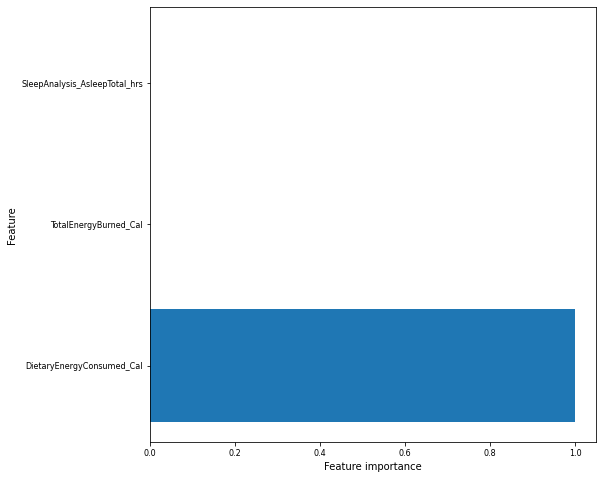

In [2853]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(clf)

OKay, we got an accuracy of 68%. This is not bad on feature 1 data.
### Decision Tree - Level 2

In [2854]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(feature_2, df['weight_loss'], random_state = 142, test_size = .25)

In [2855]:
clf = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 5, 10],
    'min_samples_split': [1, 5, 10, 20]
}

gs_tree = GridSearchCV(clf, param_grid, cv=20)
gs_tree.fit(X_train, y_train)

gs_tree.best_params_

C:\Users\benne\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
160 fits failed out of a total of 640.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\benne\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\benne\anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\Users\benne\anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 250, in fit
    raise ValueError(
ValueError: min_sa

{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 5}

In [2856]:
# Instantiate Decision Tree Classifier
clf = DecisionTreeClassifier (criterion='gini', max_depth = 1, min_samples_split = 5, random_state = 142)

# Fit the classifier
clf.fit(X_train, y_train)

# Predict on the test set
test_preds = clf.predict(X_test)

In [2857]:
X_transformed = std.fit_transform(feature_2)
scores_2 = cross_val_score(clf, X_transformed, df['weight_loss'], cv=20) #10 fold cross validation
scores_2.mean()

0.6977777777777777

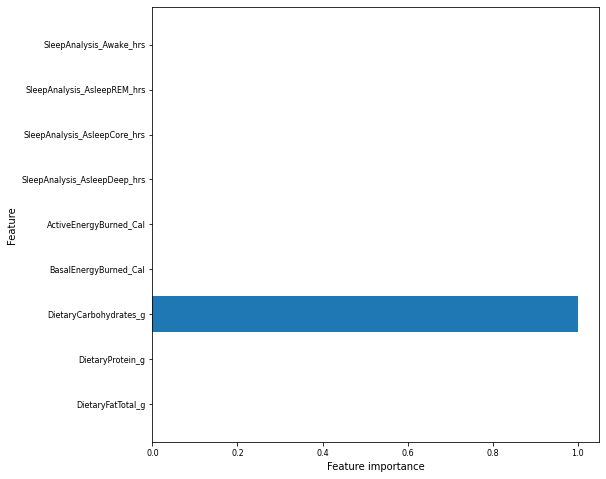

In [2858]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(clf)

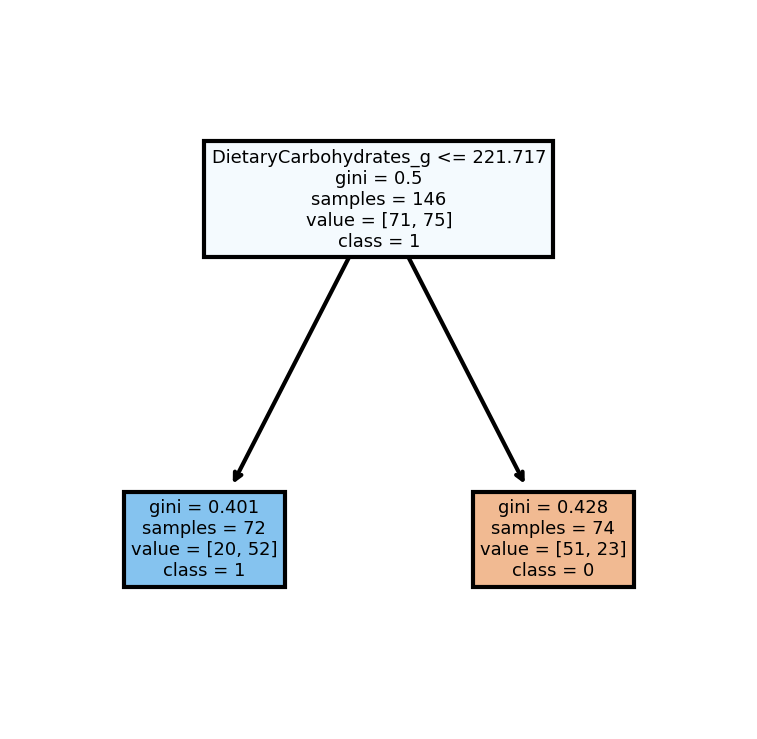

In [2859]:
from sklearn import tree

fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (3,3), dpi=300)
tree.plot_tree(clf,
               feature_names = X_train.columns, 
               class_names=np.unique(df['weight_loss']).astype('str'),
               filled = True)
plt.show()

Improvement, we've matched our best score with 70% Accuracy on our model. Let's see...
### Level 3.

In [2860]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(feature_3, df['weight_loss'], random_state = 142, test_size = .25)

In [2861]:
clf = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 5, 10],
    'min_samples_split': [1, 5, 10, 20]
}

gs_tree = GridSearchCV(clf, param_grid, cv=20)
gs_tree.fit(X_train, y_train)

gs_tree.best_params_

C:\Users\benne\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
160 fits failed out of a total of 640.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\benne\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\benne\anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\Users\benne\anaconda3\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 250, in fit
    raise ValueError(
ValueError: min_sa

{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 5}

In [2862]:
# Instantiate Decision Tree Classifier
clf = DecisionTreeClassifier (criterion='gini', max_depth = 10, min_samples_split = 5, random_state = 142)

# Fit the classifier
clf.fit(X_train, y_train)

# Predict on the test set
test_preds = clf.predict(X_test)

In [2863]:
X_transformed = std.fit_transform(feature_3)
scores_3 = cross_val_score(clf, X_transformed, df['weight_loss'], cv=20) #10 fold cross validation
scores_3.mean()

0.5605555555555556

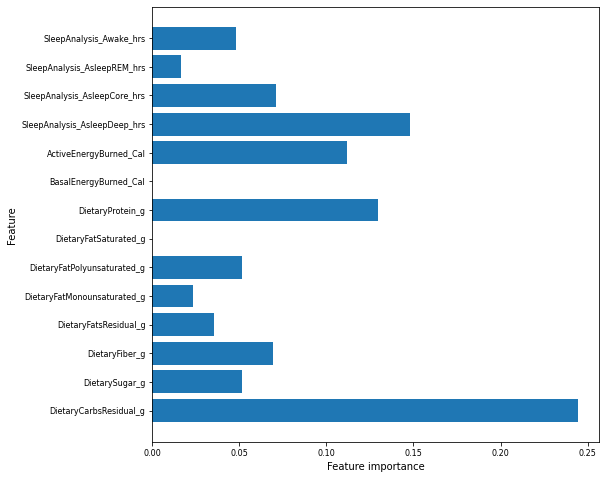

In [2864]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(clf)

Interesting... our accuracy went down with the more

### Naive Bayes 
### Level 1
theorem and see if that helps.

In [2865]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(feature_1, df['weight_loss'], random_state = 42, test_size = .25)

In [2866]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

#Guassian
GNB = GaussianNB()
GNB.fit(X_train,y_train)
#
# Predict for test set
#
y_pred = GNB.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.50      0.58      0.54        19
           1       0.70      0.63      0.67        30

    accuracy                           0.61        49
   macro avg       0.60      0.61      0.60        49
weighted avg       0.62      0.61      0.62        49



In [2867]:
X_transformed = std.fit_transform(feature_1)
scores_1 = cross_val_score(GNB, X_transformed, df['weight_loss'], cv=20) #10 fold cross validation
scores_1.mean()

0.6544444444444445

Accuracy of 65%. Not as good as our previous answers but not bad.
### Naive Bayes 
### Level 2
theorem and see if that helps.

In [2868]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(feature_2, df['weight_loss'], random_state = 42, test_size = .25)

In [2869]:
#Guassian
GNB = GaussianNB()
GNB.fit(X_train,y_train)

GaussianNB()

In [2870]:
X_transformed = std.fit_transform(feature_2)
scores_2 = cross_val_score(GNB, X_transformed, df['weight_loss'], cv=20) #10 fold cross validation
scores_2.mean()

0.5944444444444444

Accuracy of 59%. Not as good as our previous answers but not bad.
### Naive Bayes 
### Level 3
theorem and see if that helps.

In [2871]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(feature_3, df['weight_loss'], random_state = 42, test_size = .25)

In [2872]:
#Guassian
GNB = GaussianNB()
GNB.fit(X_train,y_train)

GaussianNB()

In [2873]:
X_transformed = std.fit_transform(feature_3)
scores_3 = cross_val_score(GNB, X_transformed, df['weight_loss'], cv=20) #10 fold cross validation
scores_3.mean()

0.6055555555555555

Okay, so that didn't do much either. Our Naive Bayes first model yeilded a result of .53. So... not that good. 

Okay, we got 70% true with Gaussian. This is, arguably our best result. Something to keep in mind as we go forward.

### SVM
#### Level 1
Let's do an analysis of linear SVM. We'll avoid non-linear for now as the level of complexity might be too high for a binomial classification

In [2874]:
from sklearn import svm

# Split the data
X_train, X_test, y_train, y_test = train_test_split(feature_1, df['weight_loss'], random_state = 142, test_size = .25)

In [2875]:
std = StandardScaler()
X_train_transformed = std.fit_transform(X_train)
X_test_transformed = std.transform(X_test)

In [2876]:
from sklearn import svm

#r_range = np.array([0.01, 1, 10])  
#gamma_range = np.array([0.001, 0.01, 0.1]) 
#param_grid = dict(gamma=gamma_range, coef0=r_range)
#details = []
#for gamma in gamma_range:
#     for r in r_range:
#        clf = svm.SVC(kernel='linear', coef0=r , gamma=gamma)
#        clf.fit(X_train_transformed, y_train)
#        score = clf.score(X_test_transformed, y_test)
#        details.append((r, gamma, clf, score))

In [2877]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train_transformed, y_train)

SVC(kernel='linear')

In [2878]:
clf.score(X_test_transformed, y_test)

0.6530612244897959

In [2879]:
X_transformed = std.fit_transform(feature_1)

scores_1 = cross_val_score(clf, X_transformed, df['weight_loss'], cv=20) #10 fold cross validation
scores_1.mean()

0.6455555555555555

In [2880]:
#.get_params()

<AxesSubplot:title={'center':'Weight Loss Contributors'}>

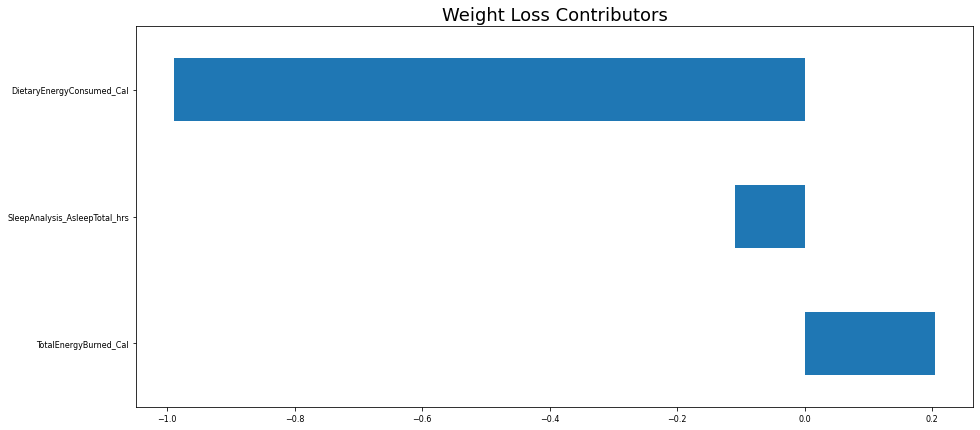

In [2881]:
#wow, let's plot the feature importance
pd.Series(clf.coef_[0], index=X_train.columns).nlargest(11).plot(kind='barh', title='Weight Loss Contributors')

65% on an SVM model is good. Let's see if we can improve it.
### SVM
#### Level 2
Let's do an analysis of linear SVM. We'll avoid non-linear for now as the level of complexity might be too high for a binomial classification

In [2882]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(feature_2, df['weight_loss'], random_state = 142, test_size = .25)

In [2883]:
std = StandardScaler()
X_train_transformed = std.fit_transform(X_train)
X_test_transformed = std.transform(X_test)

In [2884]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train_transformed, y_train)

SVC(kernel='linear')

In [2885]:
X_transformed = std.fit_transform(feature_2)

scores_2 = cross_val_score(clf, X_transformed, df['weight_loss'], cv=20) #10 fold cross validation
scores_2.mean()

0.5861111111111111

<AxesSubplot:title={'center':'Weight Loss Contributors'}>

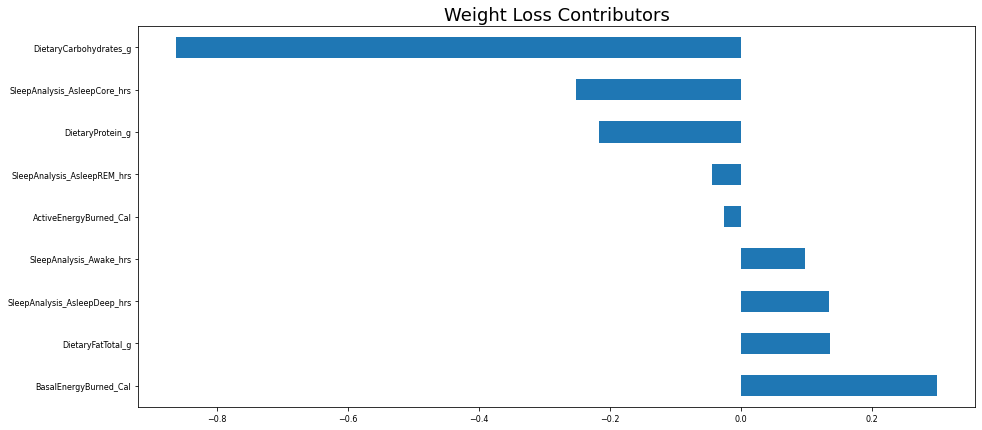

In [2886]:
#wow, let's plot the feature importance
pd.Series(clf.coef_[0], index=X_train.columns).nlargest(11).plot(kind='barh', title='Weight Loss Contributors')

65% on an SVM model is good. Let's see if we can improve it.
### SVM
#### Level 3

In [2887]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(feature_3, df['weight_loss'], random_state = 142, test_size = .25)

Okay, so after a few SVM rounds, it appears we don't have great luck

In [2888]:
std = StandardScaler()
X_train_transformed = std.fit_transform(X_train)
X_test_transformed = std.transform(X_test)

In [2889]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train_transformed, y_train)

SVC(kernel='linear')

In [2890]:
X_transformed = std.fit_transform(feature_3)

scores_2 = cross_val_score(clf, X_transformed, df['weight_loss'], cv=20) #10 fold cross validation
scores_2.mean()

0.6161111111111112

<AxesSubplot:title={'center':'Weight Loss Contributors'}>

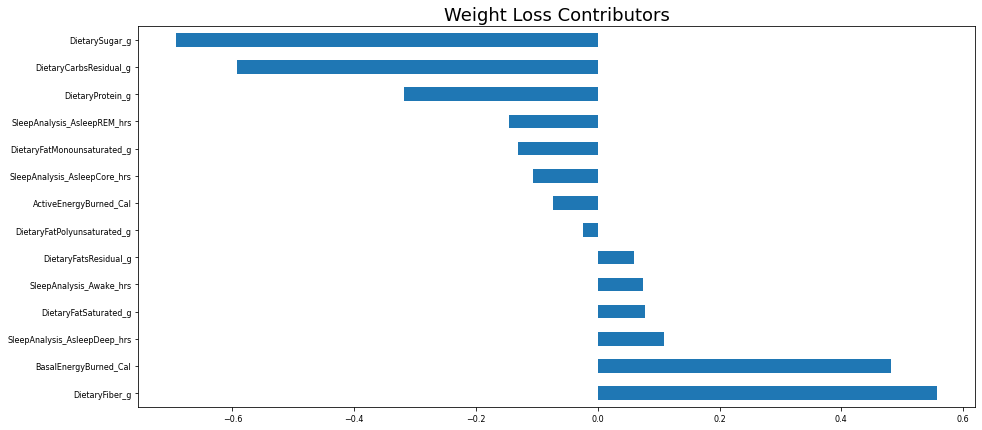

In [2891]:
#wow, let's plot the feature importance
pd.Series(clf.coef_[0], index=X_train.columns).nlargest(14).plot(kind='barh', title='Weight Loss Contributors')

### Deep Learning

In [2892]:
import keras
from keras.models import Sequential
from keras.layers import Dense
#from sklearn.preprocessing import StandardScaler, LabelBinarizer

In [2893]:
# Split the data
X_train_total, X_test, y_train_total, y_test = train_test_split(feature_1, df['weight_loss'], random_state = 124, test_size = .25)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X_train_total, y_train_total, random_state = 124, test_size = .25)

In [2894]:
# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_val = scaler.fit_transform(X_val)

In [2895]:
model_1 = Sequential()

#we'll start with 10 neurons, and an input shape of 14
model_1.add(Dense(12, activation='relu', input_shape=(3,)))
model_1.add(Dense(6, activation='tanh'))
model_1.add(Dense(2, activation='relu'))

#output classification layer
model_1.add(Dense(1, activation='sigmoid'))

In [2896]:
from keras import optimizers
# Compile the model
model_1.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])

In [2897]:
#fit model
results_1  = model_1.fit(scaled_data_train,
                    y_train,
                    epochs=100,
                    validation_data=(scaled_data_val, y_val))

Epoch 1/100
4/4 [==============================] - 1s 114ms/step - loss: 0.6864 - acc: 0.4862 - val_loss: 0.7159 - val_acc: 0.3784
Epoch 2/100
4/4 [==============================] - 0s 40ms/step - loss: 0.6833 - acc: 0.5138 - val_loss: 0.7139 - val_acc: 0.4054
Epoch 3/100
4/4 [==============================] - 0s 32ms/step - loss: 0.6812 - acc: 0.5138 - val_loss: 0.7124 - val_acc: 0.4324
Epoch 4/100
4/4 [==============================] - 0s 16ms/step - loss: 0.6788 - acc: 0.5321 - val_loss: 0.7098 - val_acc: 0.4595
Epoch 5/100
4/4 [==============================] - 0s 20ms/step - loss: 0.6765 - acc: 0.5321 - val_loss: 0.7088 - val_acc: 0.4865
Epoch 6/100
4/4 [==============================] - 0s 17ms/step - loss: 0.6748 - acc: 0.5321 - val_loss: 0.7081 - val_acc: 0.4865
Epoch 7/100
4/4 [==============================] - 0s 21ms/step - loss: 0.6733 - acc: 0.5321 - val_loss: 0.7062 - val_acc: 0.5135
Epoch 8/100
4/4 [==============================] - 0s 18ms/step - loss: 0.6712 - acc: 0.5

4/4 [==============================] - 0s 18ms/step - loss: 0.6276 - acc: 0.7339 - val_loss: 0.7062 - val_acc: 0.6486
Epoch 64/100
4/4 [==============================] - 0s 20ms/step - loss: 0.6271 - acc: 0.7339 - val_loss: 0.7060 - val_acc: 0.6486
Epoch 65/100
4/4 [==============================] - 0s 16ms/step - loss: 0.6268 - acc: 0.7248 - val_loss: 0.7060 - val_acc: 0.6486
Epoch 66/100
4/4 [==============================] - 0s 16ms/step - loss: 0.6262 - acc: 0.7248 - val_loss: 0.7061 - val_acc: 0.6486
Epoch 67/100
4/4 [==============================] - 0s 17ms/step - loss: 0.6258 - acc: 0.7248 - val_loss: 0.7058 - val_acc: 0.6486
Epoch 68/100
4/4 [==============================] - 0s 15ms/step - loss: 0.6253 - acc: 0.7156 - val_loss: 0.7059 - val_acc: 0.6486
Epoch 69/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6249 - acc: 0.7156 - val_loss: 0.7059 - val_acc: 0.6486
Epoch 70/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6243 - acc: 0.7248 - 

Okay, so we've done a fair bit of analysis here. We've used some traditional machine learning algorithms and neural networks, and we haven't exceeded 62-65% accuracy. Some of our best models were KNN, Logisitic Regression, SVM. Our worst models were Linear Regression, Naive Bayes, and Decision Tree. Because we have only numeric data, it's no surprised that Decision Tree performed poorly. The accuracy on Linear Regression was particularly bad. For now, we'll abandoned our goals of finding a combined linear regression model with time response, and just focus on classification of weight loss and weight gain.

So how do we optimize the model? A helpful analysis is there on our SVM plot. Let's look at that again.

In [2898]:
scaled_data_test = scaler.fit_transform(X_test)

score = model_1.evaluate(scaled_data_test, y_test, verbose=0)
print(score)

[0.6733395457267761, 0.6122449040412903]


Okay, so this overfit our data. It's... a lot of analysis for only 3 variables.

Let's check level 2 testing

In [2899]:
# Split the data
X_train_total, X_test, y_train_total, y_test = train_test_split(feature_2, df['weight_loss'], random_state = 124, test_size = .25)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X_train_total, y_train_total, random_state = 124, test_size = .25)

In [2900]:
# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_val = scaler.fit_transform(X_val)

In [2901]:
model_2 = Sequential()

#we'll start with 10 neurons, and an input shape of 14
model_2.add(Dense(12, activation='tanh', input_shape=(len(X_train.columns),)))
model_2.add(Dense(8, activation='tanh'))
model_2.add(Dense(4, activation='tanh'))

#output classification layer
model_2.add(Dense(1, activation='sigmoid'))

In [2902]:
from keras import optimizers
# Compile the model
model_2.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])

In [2903]:
#fit model
results_2  = model_2.fit(scaled_data_train,
                    y_train,
                    epochs=150,
                    validation_data=(scaled_data_val, y_val))

Epoch 1/150
4/4 [==============================] - 1s 89ms/step - loss: 0.6844 - acc: 0.5688 - val_loss: 0.7123 - val_acc: 0.4865
Epoch 2/150
4/4 [==============================] - 0s 29ms/step - loss: 0.6836 - acc: 0.5688 - val_loss: 0.7113 - val_acc: 0.4865
Epoch 3/150
4/4 [==============================] - 0s 25ms/step - loss: 0.6826 - acc: 0.5688 - val_loss: 0.7104 - val_acc: 0.4865
Epoch 4/150
4/4 [==============================] - 0s 18ms/step - loss: 0.6817 - acc: 0.5780 - val_loss: 0.7095 - val_acc: 0.4865
Epoch 5/150
4/4 [==============================] - 0s 21ms/step - loss: 0.6808 - acc: 0.5688 - val_loss: 0.7088 - val_acc: 0.4865
Epoch 6/150
4/4 [==============================] - 0s 17ms/step - loss: 0.6801 - acc: 0.5688 - val_loss: 0.7082 - val_acc: 0.4865
Epoch 7/150
4/4 [==============================] - 0s 17ms/step - loss: 0.6792 - acc: 0.5780 - val_loss: 0.7071 - val_acc: 0.4865
Epoch 8/150
4/4 [==============================] - 0s 18ms/step - loss: 0.6782 - acc: 0.57

4/4 [==============================] - 0s 15ms/step - loss: 0.6488 - acc: 0.6330 - val_loss: 0.6777 - val_acc: 0.5946
Epoch 64/150
4/4 [==============================] - 0s 17ms/step - loss: 0.6483 - acc: 0.6330 - val_loss: 0.6773 - val_acc: 0.5946
Epoch 65/150
4/4 [==============================] - 0s 14ms/step - loss: 0.6478 - acc: 0.6330 - val_loss: 0.6769 - val_acc: 0.5946
Epoch 66/150
4/4 [==============================] - 0s 14ms/step - loss: 0.6474 - acc: 0.6330 - val_loss: 0.6765 - val_acc: 0.5946
Epoch 67/150
4/4 [==============================] - 0s 16ms/step - loss: 0.6470 - acc: 0.6330 - val_loss: 0.6762 - val_acc: 0.5946
Epoch 68/150
4/4 [==============================] - 0s 17ms/step - loss: 0.6464 - acc: 0.6330 - val_loss: 0.6758 - val_acc: 0.5946
Epoch 69/150
4/4 [==============================] - 0s 14ms/step - loss: 0.6460 - acc: 0.6330 - val_loss: 0.6753 - val_acc: 0.5946
Epoch 70/150
4/4 [==============================] - 0s 13ms/step - loss: 0.6456 - acc: 0.6330 - 

4/4 [==============================] - 0s 17ms/step - loss: 0.6245 - acc: 0.6514 - val_loss: 0.6570 - val_acc: 0.6216
Epoch 126/150
4/4 [==============================] - 0s 15ms/step - loss: 0.6241 - acc: 0.6606 - val_loss: 0.6567 - val_acc: 0.6216
Epoch 127/150
4/4 [==============================] - 0s 16ms/step - loss: 0.6239 - acc: 0.6606 - val_loss: 0.6564 - val_acc: 0.6486
Epoch 128/150
4/4 [==============================] - 0s 15ms/step - loss: 0.6234 - acc: 0.6606 - val_loss: 0.6563 - val_acc: 0.6486
Epoch 129/150
4/4 [==============================] - 0s 15ms/step - loss: 0.6232 - acc: 0.6606 - val_loss: 0.6561 - val_acc: 0.6486
Epoch 130/150
4/4 [==============================] - 0s 14ms/step - loss: 0.6228 - acc: 0.6606 - val_loss: 0.6558 - val_acc: 0.6486
Epoch 131/150
4/4 [==============================] - 0s 16ms/step - loss: 0.6225 - acc: 0.6606 - val_loss: 0.6554 - val_acc: 0.6486
Epoch 132/150
4/4 [==============================] - 0s 15ms/step - loss: 0.6222 - acc: 0.

In [2904]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

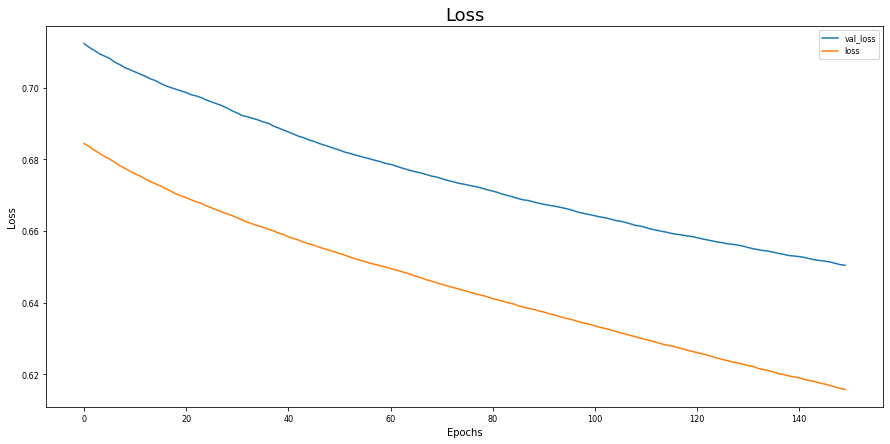

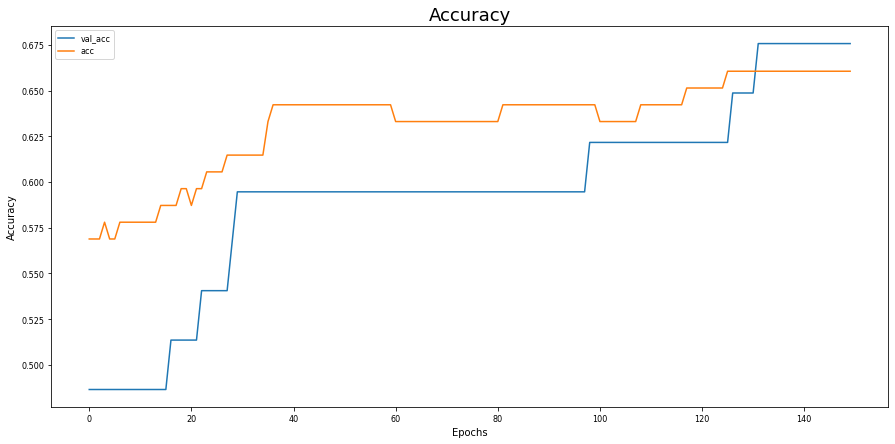

In [2905]:
visualize_training_results(results_2)

In [2906]:
scaled_data_test = scaler.fit_transform(X_test)

score = model_2.evaluate(scaled_data_test, y_test, verbose=0)
print(score)

[0.696380615234375, 0.5714285969734192]


Not good either. It appears this was overfit on both

Let's check level 3 testing

In [2907]:
# Split the data
X_train_total, X_test, y_train_total, y_test = train_test_split(feature_3, df['weight_loss'], random_state = 124, test_size = .25)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X_train_total, y_train_total, random_state = 124, test_size = .25)

In [2908]:
# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_val = scaler.fit_transform(X_val)

In [2909]:
model_3 = Sequential()

#we'll start with 10 neurons, and an input shape of 14
model_3.add(Dense(12, activation='tanh', input_shape=(len(X_train.columns),)))
model_3.add(Dense(8, activation='tanh'))
model_3.add(Dense(4, activation='tanh'))

#output classification layer
model_3.add(Dense(1, activation='sigmoid'))

In [2910]:
from keras import optimizers
# Compile the model
model_3.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])

In [2911]:
#fit model
results_3  = model_3.fit(scaled_data_train,
                    y_train,
                    epochs=100,
                    validation_data=(scaled_data_val, y_val))

Epoch 1/100
4/4 [==============================] - 1s 87ms/step - loss: 0.7050 - acc: 0.5321 - val_loss: 0.7040 - val_acc: 0.5946
Epoch 2/100
4/4 [==============================] - 0s 24ms/step - loss: 0.7037 - acc: 0.5505 - val_loss: 0.7023 - val_acc: 0.5946
Epoch 3/100
4/4 [==============================] - 0s 18ms/step - loss: 0.7023 - acc: 0.5505 - val_loss: 0.7006 - val_acc: 0.5946
Epoch 4/100
4/4 [==============================] - 0s 19ms/step - loss: 0.7006 - acc: 0.5505 - val_loss: 0.6993 - val_acc: 0.5946
Epoch 5/100
4/4 [==============================] - 0s 17ms/step - loss: 0.6991 - acc: 0.5596 - val_loss: 0.6979 - val_acc: 0.5946
Epoch 6/100
4/4 [==============================] - 0s 19ms/step - loss: 0.6977 - acc: 0.5688 - val_loss: 0.6965 - val_acc: 0.5946
Epoch 7/100
4/4 [==============================] - 0s 17ms/step - loss: 0.6962 - acc: 0.5596 - val_loss: 0.6953 - val_acc: 0.5946
Epoch 8/100
4/4 [==============================] - 0s 22ms/step - loss: 0.6950 - acc: 0.56

4/4 [==============================] - 0s 14ms/step - loss: 0.6466 - acc: 0.6239 - val_loss: 0.6433 - val_acc: 0.5946
Epoch 64/100
4/4 [==============================] - 0s 16ms/step - loss: 0.6461 - acc: 0.6239 - val_loss: 0.6429 - val_acc: 0.5946
Epoch 65/100
4/4 [==============================] - 0s 16ms/step - loss: 0.6454 - acc: 0.6239 - val_loss: 0.6423 - val_acc: 0.6216
Epoch 66/100
4/4 [==============================] - 0s 19ms/step - loss: 0.6449 - acc: 0.6239 - val_loss: 0.6416 - val_acc: 0.6216
Epoch 67/100
4/4 [==============================] - 0s 15ms/step - loss: 0.6441 - acc: 0.6239 - val_loss: 0.6407 - val_acc: 0.6216
Epoch 68/100
4/4 [==============================] - 0s 14ms/step - loss: 0.6437 - acc: 0.6239 - val_loss: 0.6400 - val_acc: 0.6216
Epoch 69/100
4/4 [==============================] - 0s 14ms/step - loss: 0.6428 - acc: 0.6239 - val_loss: 0.6393 - val_acc: 0.6216
Epoch 70/100
4/4 [==============================] - 0s 14ms/step - loss: 0.6423 - acc: 0.6239 - 

In [2912]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

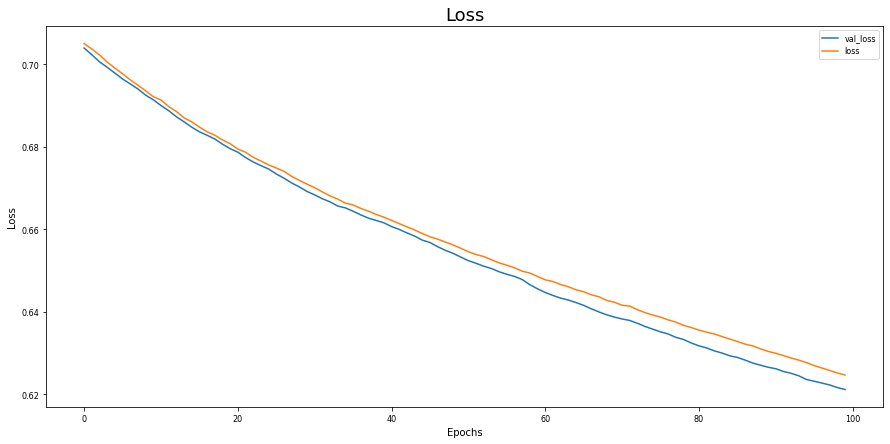

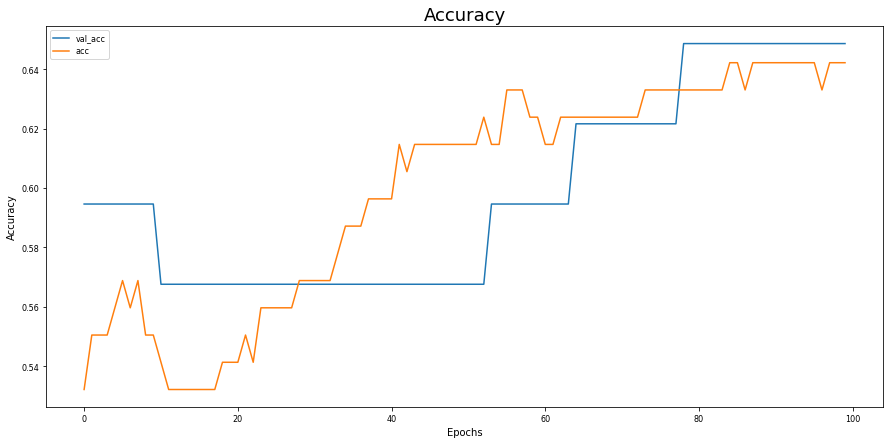

In [2913]:
visualize_training_results(results_3)

In [2914]:
scaled_data_test = scaler.fit_transform(X_test)

score = model_3.evaluate(scaled_data_test, y_test, verbose=0)
print(score)

[0.672027587890625, 0.5918367505073547]


So... it looks as though our best models our the Decision Tree with Level 2 data, and Logistic Regression with Level 1 data.
Let's go ahead and iterate on those two models.

Okay, so we achieved, 61% accuracy on test data. It's not quite what we achieved with our SVM and decision tree models

Perfect. So it turns out this model was perfect at epock 100. So let's stop the model at epoch 100 and then predict on our test data

From the importance feature above we can tell a few things.

Surprises:
1. The most important feature is Basal Energy Burned. This feature essentially tells us how heavy we are, meaning, it looks like our existing weight is the biggest predictor of whether or not we will lose weight the next day.

2. Protein is the second largest negative factor contributing to weight loss. We hear a lot about how we need more protein in our diet. It contributes to building and maintaining muscle and organ function. It's possible that weight loss is more than just fat and stored carbohydrates. It's also about losing muscle.

3. Residual fats (characterized as all fats not saturated, monounsaturated, and polyunsaturated) are a small contributor to weight loss. We hear sometimes about "healthy fats" but interesting to see it as a 3rd largest contributor to weight loss.

4. Active Calorie burned was a contributing factor too... weight gain? It's incredibly small, so perhaps with more data, we can get a different result. But regardless, it seems that active calorie burn was insignificant, or even a negative coefficient, to weight loss.

Expected:
1. REM sleep and Core Sleep both factor into some weight loss, however Deep sleep factors slightly against. The deep sleep coefficient is so small, that it seems as though Total sleep hours would be a more significant factor for next day weight loss.

2. Dietary Fiber is the second most important factor contributing to weight loss. This is interesting because we here that having lots of fiber in your diet is important.

3. Sugar is the largest negative factor contributing to weight loss. This confirms what we've heard for a while. Interesting to see it here.

4. Saturated and Polyunsaturated fats were negative contributors to weight loss, with polyunsaturated fats being the largest contributor. 

Next steps. Well, we can combine the sleep into one category, that would simplify the analysis, especially from a PCA perspective. We can also add some rolling sums. As we mentioned before, we didn't have much luck doing a time response strictly with the weight data, but perhaps we could include both rolling sums of the data, as well as an indication if there was weight loss the dat before our after.

So... let's resume Decision Tree, Logistic Regression, linear SVM 

First, we'll consolidate the sleep data - we'll leave the hours awake data out, 
Second, we'll add a 2 day rolling average to each of the numbers.
Third, we'll add a previous day weight loss component.

### Sleep Consolidation

In [2915]:
#let's create our dataset
sleep_consolidation = df[level_3_diet + level_2_exer + level_1_sleep]
targets = df['weight_loss']

### KNN
okay, let's run a KNN model with updated sleep and see if there's any budge.

In [2916]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(sleep_consolidation, targets, test_size=0.25, random_state=24)

# Standardize the data
std = StandardScaler()
X_train_transformed = std.fit_transform(X_train)
X_test_transformed = std.transform(X_test)


In [2917]:
#let's search for the best K for our algorithm
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = f1_score(y_test, preds)
        if f1 > best_score:
            best_k = k
            best_score = f1
    
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))

In [2918]:
find_best_k(X_train_transformed, y_train, X_test_transformed, y_test)

Best Value for k: 11
F1-Score: 0.723404255319149


In [2919]:
# Instantiate KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=11)

# Fit the classifier
clf.fit(X_train_transformed, y_train)

# Predict on the test set
test_preds = clf.predict(X_test_transformed)

In [2920]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))
    
print_metrics(y_test, test_preds)

Precision Score: 0.85
Recall Score: 0.6296296296296297
Accuracy Score: 0.7346938775510204
F1 Score: 0.723404255319149


In [2921]:
#let's cross-validate
X_transformed = std.transform(sleep_consolidation)

scores = cross_val_score(clf, X_transformed, targets, cv=10)
scores.mean()

0.6468421052631579

### Logistic Regression

In [2922]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(sleep_consolidation, targets, test_size=0.25, random_state=24)

# Standardize the data
std = StandardScaler()
X_train_transformed = std.fit_transform(X_train)
X_test_transformed = std.transform(X_test)

X_transformed = std.transform(sleep_consolidation)

In [2923]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(fit_intercept=False, C=100, solver='liblinear')
model_log = logreg.fit(X_train_transformed, y_train)
model_log

LogisticRegression(C=100, fit_intercept=False, solver='liblinear')

In [2924]:
y_hat_train = model_log.predict(X_train_transformed)

train_residuals = np.abs(y_train - y_hat_train)
print(pd.Series(train_residuals, name="Residuals (counts)").value_counts())
print()
print(pd.Series(train_residuals, name="Residuals (proportions)").value_counts(normalize=True))

Residuals (counts)
0    103
1     43
Name: count, dtype: int64

Residuals (proportions)
0    0.705479
1    0.294521
Name: proportion, dtype: float64


In [2925]:
y_hat_test = model_log.predict(X_test_transformed)

test_residuals = np.abs(y_test - y_hat_test)
print(pd.Series(test_residuals, name="Residuals (counts)").value_counts())
print()
print(pd.Series(test_residuals, name="Residuals (proportions)").value_counts(normalize=True))

Residuals (counts)
0    31
1    18
Name: count, dtype: int64

Residuals (proportions)
0    0.632653
1    0.367347
Name: proportion, dtype: float64


In [2926]:
#let's cross-validate
scores = cross_val_score(model_log, X_transformed, targets, cv=10)
scores.mean()

0.6473684210526315

65%   mean accuracy on cross-validation is not very good.


### SVM 


In [2927]:
# Split the data
#X_train, X_test, y_train, y_test = train_test_split(sleep_consolidation, targets, random_state = 42, test_size = .99)

In [2928]:
# Standardize the data
std = StandardScaler()
X_train_transformed = std.fit_transform(sleep_consolidation)
#X_test_transformed = std.transform(X_test)

X_transformed = std.transform(sleep_consolidation) 

In [2929]:
from sklearn import svm

svm = svm.SVC(kernel='linear')
svm.fit(X_train_transformed, targets)

#svm.score(X_test_transformed, y_test)

SVC(kernel='linear')

In [2930]:
scores = cross_val_score(svm, X_transformed, targets, cv=15)
scores.mean()

0.6461538461538462

<AxesSubplot:title={'center':'                         <----- Weight Gain | Weight Loss ----->'}>

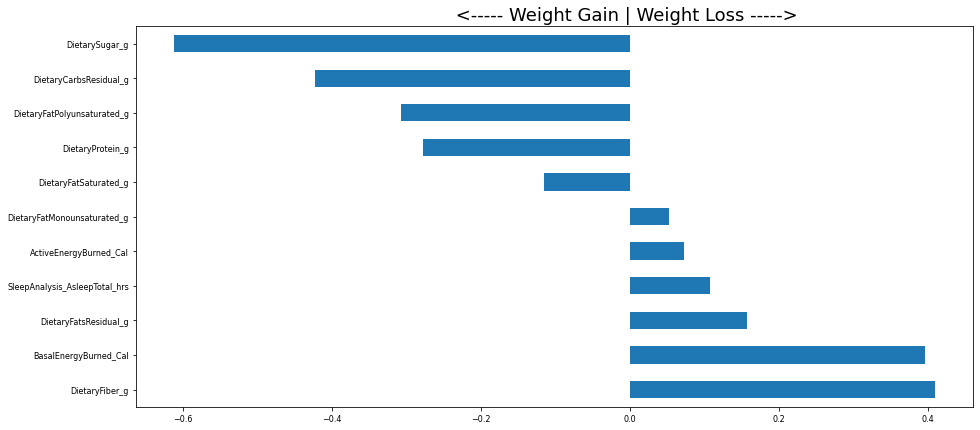

In [2931]:
#wow, let's plot the feature importance
pd.Series(svm.coef_[0], index=sleep_consolidation.columns).nlargest(11).plot(kind='barh', title='                         <----- Weight Gain | Weight Loss ----->')

Okay, so we were able to 67% accuracy on mean cross-validation. This is an improvement. Additionally, once we consolidated the sleep factors (and removed awake time), we see a decent increase in the contribution of Dietary Sugar. The active calorie burned stayed relatively small, almost nonexistent.

In [2932]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(sleep_consolidation, targets, random_state = 243, test_size = .25)

# Split the data
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, random_state = 243, test_size = .25)

In [2933]:
# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
X_train_transform = scaler.fit_transform(X_train_final)
X_val_transform = scaler.fit_transform(X_val)

In [2934]:
model_1 = Sequential()

#we'll start with 10 neurons, and an input shape of 14
model_1.add(Dense(12, activation='relu', input_shape=(11,)))
model_1.add(Dense(8, activation='relu'))
model_1.add(Dense(4, activation='relu'))

#output classification layer
model_1.add(Dense(1, activation='sigmoid'))

In [2935]:
from keras import optimizers
# Compile the model
model_1.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])

In [2936]:
#fit model
results_1  = model_1.fit(X_train_transform,
                    y_train_final,
                    epochs=75,
                    validation_data=(X_val_transform, y_val))

Epoch 1/75
4/4 [==============================] - 1s 100ms/step - loss: 0.6894 - acc: 0.5505 - val_loss: 0.6804 - val_acc: 0.5676
Epoch 2/75
4/4 [==============================] - 0s 18ms/step - loss: 0.6891 - acc: 0.5596 - val_loss: 0.6802 - val_acc: 0.5676
Epoch 3/75
4/4 [==============================] - 0s 21ms/step - loss: 0.6888 - acc: 0.5596 - val_loss: 0.6801 - val_acc: 0.5676
Epoch 4/75
4/4 [==============================] - 0s 19ms/step - loss: 0.6884 - acc: 0.5596 - val_loss: 0.6799 - val_acc: 0.5676
Epoch 5/75
4/4 [==============================] - 0s 20ms/step - loss: 0.6881 - acc: 0.5596 - val_loss: 0.6797 - val_acc: 0.5676
Epoch 6/75
4/4 [==============================] - 0s 21ms/step - loss: 0.6878 - acc: 0.5780 - val_loss: 0.6796 - val_acc: 0.5676
Epoch 7/75
4/4 [==============================] - 0s 24ms/step - loss: 0.6876 - acc: 0.5780 - val_loss: 0.6796 - val_acc: 0.5676
Epoch 8/75
4/4 [==============================] - 0s 18ms/step - loss: 0.6874 - acc: 0.5688 - va

4/4 [==============================] - 0s 16ms/step - loss: 0.6724 - acc: 0.6514 - val_loss: 0.6704 - val_acc: 0.6757
Epoch 65/75
4/4 [==============================] - 0s 15ms/step - loss: 0.6722 - acc: 0.6514 - val_loss: 0.6702 - val_acc: 0.7027
Epoch 66/75
4/4 [==============================] - 0s 16ms/step - loss: 0.6719 - acc: 0.6514 - val_loss: 0.6700 - val_acc: 0.7027
Epoch 67/75
4/4 [==============================] - 0s 17ms/step - loss: 0.6717 - acc: 0.6514 - val_loss: 0.6697 - val_acc: 0.7297
Epoch 68/75
4/4 [==============================] - 0s 14ms/step - loss: 0.6714 - acc: 0.6606 - val_loss: 0.6694 - val_acc: 0.7297
Epoch 69/75
4/4 [==============================] - 0s 18ms/step - loss: 0.6712 - acc: 0.6606 - val_loss: 0.6692 - val_acc: 0.7297
Epoch 70/75
4/4 [==============================] - 0s 17ms/step - loss: 0.6709 - acc: 0.6697 - val_loss: 0.6688 - val_acc: 0.7297
Epoch 71/75
4/4 [==============================] - 0s 15ms/step - loss: 0.6706 - acc: 0.6697 - val_los

In [2937]:
# Transform the training and test sets
X_train_transform_1 = scaler.fit_transform(X_train)
X_test_transform = scaler.fit_transform(X_test)

In [2938]:
results_train = model_1.evaluate(X_train_transform_1, y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

5/5 [==============================] - 0s 2ms/step - loss: 0.6729 - acc: 0.6438
----------
Training Loss: 0.673 
Training Accuracy: 0.644


In [2939]:
results_train = model_1.evaluate(X_test_transform, y_test)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

2/2 [==============================] - 0s 4ms/step - loss: 0.6981 - acc: 0.6939
----------
Training Loss: 0.698 
Training Accuracy: 0.694


Okay, so we don't have much improvement here. In fact, we got a decrease from our SVM model, which, so far, has the best output.

But let's continue with our modeling. Let's do a two day rolling sum of the all of the features and see if that changes anything.

### 2 Day Rolling Sum
Previously we created a sleep_consolidation set, that looked something like this.
`sleep_consolidation = df[level_3_diet + level_2_exer + level_1_sleep]`

so, let's take our new df, and


In [2940]:
#let's create our dataset
newdf_roll_sum_2 = sleep_consolidation.rolling(2).sum().drop(['2023-08-24'], axis = 0)
#y.drop('2023-08-25', axis = 0,inplace = True)
newdf_roll_sum_2

targets_roll_sum_2 = targets.drop(['2023-08-24'], axis = 0)
targets_roll_sum_2

date
2023-08-25    1
2023-08-26    1
2023-08-27    1
2023-08-28    0
2023-08-29    1
             ..
2024-03-01    0
2024-03-02    0
2024-03-03    0
2024-03-04    1
2024-03-05    1
Name: weight_loss, Length: 194, dtype: int32

# KNN

In [2941]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(newdf_roll_sum_2, targets_roll_sum_2, test_size=0.25, random_state=24)

# Standardize the data
std = StandardScaler()
X_train_transformed = std.fit_transform(X_train)
X_test_transformed = std.transform(X_test)


#let's search for the best K for our algorithm
find_best_k(X_train_transformed, y_train, X_test_transformed, y_test)
    

In [2942]:
# Instantiate KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=11)

# Fit the classifier
clf.fit(X_train_transformed, y_train)

# Predict on the test set
test_preds = clf.predict(X_test_transformed)

In [2943]:
#let's cross-validate
X_transformed = std.transform(newdf_roll_sum_2)

scores = cross_val_score(clf, X_transformed, targets_roll_sum_2, cv=10)
scores.mean()

0.5531578947368421

### Logistic Regression

In [2944]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(newdf_roll_sum_2, targets_roll_sum_2, test_size=0.25, random_state=24)

# Standardize the data
std = StandardScaler()
X_train_transformed = std.fit_transform(X_train)
X_test_transformed = std.transform(X_test)

X_transformed = std.transform(newdf_roll_sum_2)

In [2945]:
#from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(fit_intercept=False, C=1E12, solver='liblinear')
model_log = logreg.fit(X_train_transformed, y_train)
model_log

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [2946]:
#let's cross-validate
scores = cross_val_score(model_log, X_transformed, targets_roll_sum_2, cv=10)
scores.mean()

0.5986842105263157

### SVM

In [2947]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(newdf_roll_sum_2, targets_roll_sum_2, test_size=0.25, random_state=24)

# Standardize the data
std = StandardScaler()
X_train_transformed = std.fit_transform(X_train)
X_test_transformed = std.transform(X_test)

X_transformed = std.transform(newdf_roll_sum_2)

In [2948]:
from sklearn import svm

svm = svm.SVC(kernel='linear')
svm.fit(X_train_transformed, y_train)

svm.score(X_test_transformed, y_test)

0.6326530612244898

In [2949]:
scores = cross_val_score(svm, newdf_roll_sum_2, targets_roll_sum_2, cv=15)
scores.mean()

0.6081196581196583

<AxesSubplot:title={'center':'Weight Loss Contributors'}>

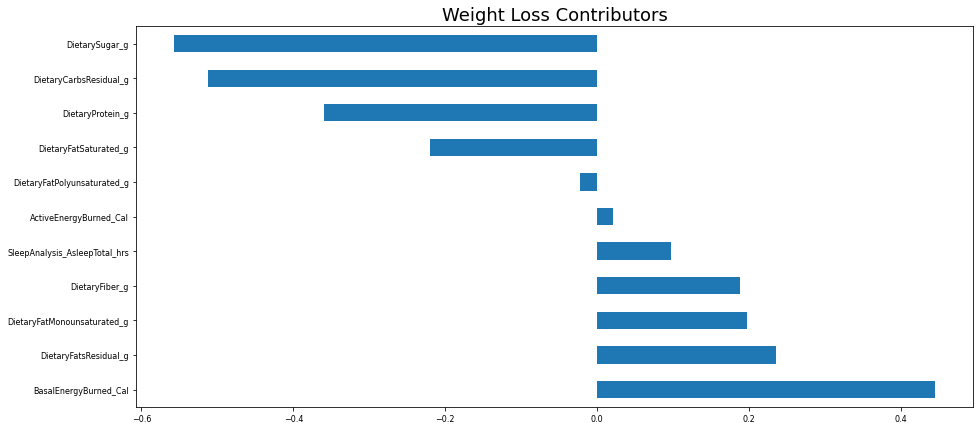

In [2950]:
#wow, let's plot the feature importance
pd.Series(svm.coef_[0], index=X_train.columns).nlargest(14).plot(kind='barh', title='Weight Loss Contributors')

### Neural Network

In [2951]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(newdf_roll_sum_2, targets_roll_sum_2, random_state = 24, test_size = .15)

# Split the data
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, random_state = 24, test_size = .15)

In [2952]:
# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
X_train_transform = scaler.fit_transform(X_train_final)
X_val_transform = scaler.fit_transform(X_val)


In [2953]:
model_1 = Sequential()

#we'll start with 10 neurons, and an input shape of 14
model_1.add(Dense(12, activation='tanh', input_shape=(11,)))
model_1.add(Dense(8, activation='tanh'))
model_1.add(Dense(4, activation='tanh'))

#output classification layer
model_1.add(Dense(1, activation='sigmoid'))

In [2954]:
# Compile the model
model_1.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])

In [2955]:
#fit model
results_1  = model_1.fit(X_train_transform,
                    y_train_final,
                    epochs=75,
                    validation_data=(X_val_transform, y_val))

Epoch 1/75
5/5 [==============================] - 1s 87ms/step - loss: 0.6876 - acc: 0.5252 - val_loss: 0.5937 - val_acc: 0.7600
Epoch 2/75
5/5 [==============================] - 0s 17ms/step - loss: 0.6853 - acc: 0.5252 - val_loss: 0.5918 - val_acc: 0.7600
Epoch 3/75
5/5 [==============================] - 0s 17ms/step - loss: 0.6829 - acc: 0.5324 - val_loss: 0.5911 - val_acc: 0.7600
Epoch 4/75
5/5 [==============================] - 0s 16ms/step - loss: 0.6808 - acc: 0.5396 - val_loss: 0.5904 - val_acc: 0.7600
Epoch 5/75
5/5 [==============================] - 0s 15ms/step - loss: 0.6783 - acc: 0.5468 - val_loss: 0.5898 - val_acc: 0.7600
Epoch 6/75
5/5 [==============================] - 0s 18ms/step - loss: 0.6763 - acc: 0.5540 - val_loss: 0.5885 - val_acc: 0.8000
Epoch 7/75
5/5 [==============================] - 0s 16ms/step - loss: 0.6741 - acc: 0.5540 - val_loss: 0.5878 - val_acc: 0.8000
Epoch 8/75
5/5 [==============================] - 0s 18ms/step - loss: 0.6718 - acc: 0.5755 - val

5/5 [==============================] - 0s 12ms/step - loss: 0.6149 - acc: 0.6978 - val_loss: 0.5746 - val_acc: 0.7600
Epoch 65/75
5/5 [==============================] - 0s 14ms/step - loss: 0.6145 - acc: 0.6978 - val_loss: 0.5750 - val_acc: 0.7600
Epoch 66/75
5/5 [==============================] - 0s 13ms/step - loss: 0.6140 - acc: 0.6978 - val_loss: 0.5746 - val_acc: 0.7600
Epoch 67/75
5/5 [==============================] - 0s 12ms/step - loss: 0.6136 - acc: 0.6978 - val_loss: 0.5753 - val_acc: 0.7600
Epoch 68/75
5/5 [==============================] - 0s 11ms/step - loss: 0.6132 - acc: 0.7050 - val_loss: 0.5749 - val_acc: 0.7600
Epoch 69/75
5/5 [==============================] - 0s 13ms/step - loss: 0.6126 - acc: 0.7050 - val_loss: 0.5754 - val_acc: 0.7600
Epoch 70/75
5/5 [==============================] - 0s 13ms/step - loss: 0.6120 - acc: 0.7050 - val_loss: 0.5757 - val_acc: 0.7600
Epoch 71/75
5/5 [==============================] - 0s 11ms/step - loss: 0.6117 - acc: 0.6978 - val_los

### SUMMARY
So, we did not see an improvement with the addition of the rolling sum for 2 days. But I still would like to test some sort of time response idea. Let's see if we can add a feature to represent the previous day was weight loss or weight gain.

### Add another feature - previous day's weight loss or gain.
So, we know that the rolling sum didn't help. Let's return to our previous day weight gain idea. I'm going to circle back to the Decision Tree - Level 2 and Logistic Regression - Level 1. 

### SUMMARY
We downloaded the data, analyzed it, and decided to run some more analysis.

### Pipeline, 
let's establish pipelines for each of our tests. We won't necessarily worry about some of our less accurate ones, but we can start with the basics. We've had good results for Naive Bayes, KNN, and SVM. So, let's run a few test